In [ ]:
import os
import sys
import numpy as np
from pathlib import Path
from time import time
import pickle
import logging
from astropy.table import Table
import orpheus
from matplotlib import pyplot as plt

In [2]:
nbar = 8
len_1 = 600.
len_2 = 600.
ngal = int(nbar*len_1*len_2)
nbinsz = 5
sigma_eps_comp = 0.25
pos1 = len_1*np.random.rand(ngal)
pos2 = len_2*np.random.rand(ngal)
shape1 = np.random.normal(loc=0,scale=sigma_eps_comp,size=ngal)
shape2 = np.random.normal(loc=0,scale=sigma_eps_comp,size=ngal)
zbins = np.random.randint(0,nbinsz,ngal)    
print(ngal)

2880000


In [3]:
cat = orpheus.Catalog(pos1=pos1, pos2=pos2, zbins=zbins)
scat = orpheus.SpinTracerCatalog(spin=2, pos1=pos1, pos2=pos2, tracer_1=shape1, tracer_2=shape2, zbins=zbins)

In [5]:
fields = [shape1 + 1J*shape2]
dpix = .5
tomo=False

In [6]:
%%time
cat_red, fields_red = cat._reduce(fields=fields, dpix=dpix, tomo=tomo, normed=False, ret_inst=True)

CPU times: user 975 ms, sys: 127 ms, total: 1.1 s
Wall time: 1.1 s


In [7]:
print(np.sum(cat.weight))
print(np.sum(cat_red.weight))

2880000.0
2880000.0


In [8]:
dpixs = [1.,4.]
res = scat.multihash(dpixs=dpixs,tomo=False,shuffle=True)
(ngals, pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals) = res

0.00024839941030752044 5.992514884312072e-06 599.9997334126301 599.9997867351334
-7.9997516005896925 -7.999994007485116 607.9997334126301 607.9997867351334
153 153 4.026140424923005 4.0261423577948925
1.0 2880000
0.0009801050985883682 0.00011850419819213844 599.9979473299671 599.9981205048159
-7.9997516005896925 -7.999994007485116 607.9997334126301 607.9997867351334
153 153 4.026140424923005 4.0261423577948925
4.0 2880000
0.1341281914178692 0.006011473403186508 599.9707157880265 599.9778408467795
-7.9997516005896925 -7.999994007485116 607.9997334126301 607.9997867351334
153 153 4.026140424923005 4.0261423577948925


In [ ]:
_1 = 5
_2 = 5
elz = 0
dpix_h = 2.
colors = ["red", "grey","blue","black"]
for elreso in range(len(ngals)):
    color=colors[elreso]#"grey"
    if elreso==len(ngals)-1:color="black"
    sel = (zbins[elreso]==elz) * (pos1s[elreso]<_1) * (pos2s[elreso]<_2)
    plt.scatter(pos1s[elreso][sel],pos2s[elreso][sel],color=color,s=1+3*elreso,label=elreso)
    if elreso>0:
        for i in range(int((_1)//dpixs[elreso-1])+1):
            plt.axhline(i*dpixs[elreso-1],color=color,ls=":",lw=1+.5*elreso)
            plt.axvline(i*dpixs[elreso-1],color=color,ls=":",lw=1+.5*elreso)
plt.legend(loc="upper right")
plt.axis('equal')


In [9]:
for elres in range(4):
    print(ngals, len(pos1s[elres]), len(index_matchers[elres]), len(pixs_galind_bounds[elres]), len(pix_gals[elres]))

[2880000, 2265754, 1245509, 359886] 2880000 363609 2880001 2880000
[2880000, 2265754, 1245509, 359886] 2265754 363609 2265755 2265754
[2880000, 2265754, 1245509, 359886] 1245509 363609 1245510 1245509
[2880000, 2265754, 1245509, 359886] 359886 363609 359887 359886


In [10]:
n_cfs = 4
min_sep = 80.
max_sep = 320.
nbinsr = 50

threepcf = orpheus.GGGCorrelation(n_cfs, min_sep, max_sep, binsize=.1,method="Discrete")

[2 2 2]
Do we add
We add


In [18]:
redscat = scat.reduce(4., ret_inst=True)
redscat.build_spatialhash(dpix=2.76)

1.7103460967196886 1.76304020216369 598.2751854958276 598.2481295850262
-1.0496539032803112 -0.9969597978363098 601.0351854958276 601.0081295850262
218 218 2.7618570614637976 2.7614912357012042


In [19]:
%%time
threeres = threepcf.process(redscat, nthreads=16)

CPU times: user 3min 14s, sys: 259 ms, total: 3min 15s
Wall time: 15.7 s


In [20]:
%%time
threepcf.multipoles2npcf()

CPU times: user 337 ms, sys: 4 ms, total: 341 ms
Wall time: 337 ms


In [22]:
threepcf.projectnpcf("Centroid")

In [21]:
threepcf.projection

'X'

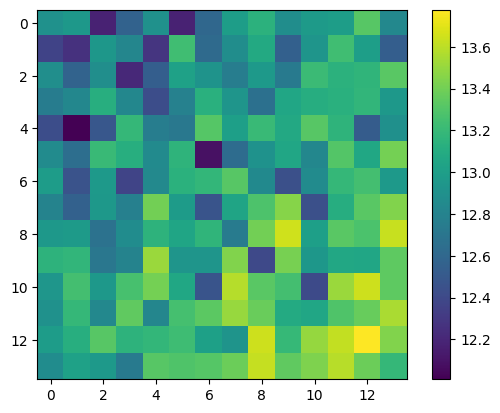

In [17]:
plt.imshow(np.log10(np.abs(threepcf.npcf_multipoles[3,0,0])))
plt.colorbar()

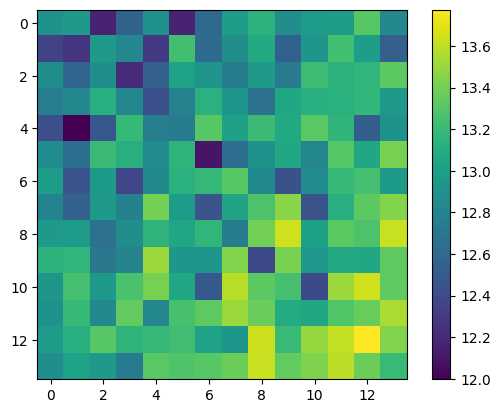

In [23]:
plt.imshow(np.log10(np.abs(threepcf.npcf_multipoles[3,0,0])))
plt.colorbar()

In [24]:
threepcf._gen_npcfprojections_avail(threepcf)

The following projections for are available in the class GGGCorrelation:
  None --> None
  X --> X
  X --> Centroid
  Centroid --> Centroid


/cosma7/data/dp004/dc-port3/miniconda3/envs/3PointEnv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


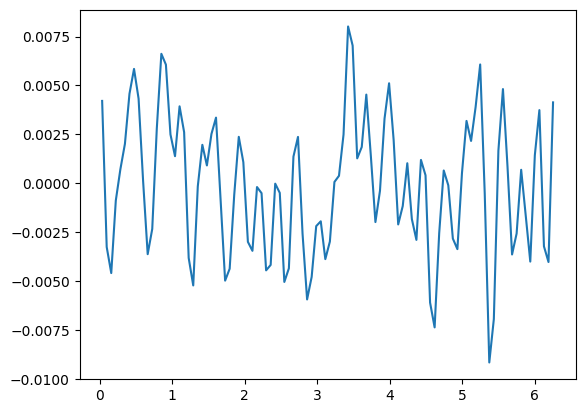

In [25]:
plt.plot(threepcf.phi, threepcf.npcf[0,0,11,4])

In [61]:
threepcf.spins

array([2, 2, 2], dtype=int32)

In [74]:
weight = np.zeros(3)
kwargs = {"k1":None, "k2":[weight,weight,weight]}
ntracers = 3
for key in kwargs.keys():
    if kwargs[key] is None:
        kwargs[key] = [None]*ntracers
    else:
        assert(len(kwargs[key][0])==len(weight))
    print(key, kwargs[key])
    
    

k1 None
k1 [None, None, None]
k2 [array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.])]
k2 [array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.])]


In [100]:
class Parent:
    
    def __init__(self, a, b):
        self.a = a
        self.b = b
    
    def _func(self, Child, d):
        return self.a + self.b + Child.c + d
    

class Child(Parent):
    
    def __init__(self, a, b, c):
        super().__init__(a, b)
        self.c = c
        
    def func(self, d, e):
        return self._func(self, d) + e
        
child = Child(1,2,3)
child.func(4, 5)

15

In [114]:
def funca(a, b, c):
    return a+b+c

def funcb(a, b, c, d):
    return a+b+c+d

func = funca
args = ()
args += (1,)
args += (2,)
args += (3,)
func(*args)

args = ()
args += (np.ones(10),)
args += (2*np.ones(10),)
args += (3*np.ones(10),)
func(*args).astype(np.complex).dtype

/tmp/ipykernel_166659/1733296993.py:18: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  func(*args).astype(np.complex).dtype


dtype('complex128')

In [14]:
threepcf.clib.__dir__()

['_name',
 '_FuncPtr',
 '_handle',
 'alloc_Gammans_discrete_ggg',
 '__module__',
 '__doc__',
 '_func_flags_',
 '_func_restype_',
 '__init__',
 '__repr__',
 '__getattr__',
 '__getitem__',
 '__dict__',
 '__weakref__',
 '__new__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [21]:
a = 1
type(np.int32(a))

numpy.int32

In [64]:
someargs = (1, 2, np.linspace(1,2,3))
allargs = (0, *someargs, np.zeros(2))

In [65]:
allargs

(0, 1, 2, array([1. , 1.5, 2. ]), array([0., 0.]))

In [23]:
arr1 = np.zeros((4,3,5))
arr2 = np.zeros(3)
arr1[:,:,0] *= arr2[np.newaxis,:]

In [32]:
threepcf.__class__.__name__

'GGGCorrelation'

In [4]:
data


In [5]:
slicsfullreso = orpheus.SpinTracerCatalog(spin=2, pos1=pos1, pos2=pos2, tracer_1=gamma1, tracer_2=gamma2, zbins=zphot)

In [58]:
n_cfs = 4
min_sep = 0.5
max_sep_disc = 5.
max_seps = [10.,20.,40.,80.,160.]
dpixs = [0.25,0.5,1.0,2.0,4.0]
binsize=.15
threepcfs = [None]*6
cats = [None]*6
cats[0] = orpheus.SpinTracerCatalog(spin=2, pos1=pos1, pos2=pos2, tracer_1=gamma1, tracer_2=-gamma2, zbins=None)
threepcfs[0] = orpheus.GGGCorrelation(n_cfs, min_sep, max_sep_disc, binsize=binsize, method="Discrete")
threepcfs[0].process(cats[0], nthreads=16)
threepcfs[0].multipoles2npcf()
for elsep, maxsep in enumerate(max_seps):
    print(elsep)
    cats[elsep+1] = cats[0].reduce(dpixs[elsep], ret_inst=True)
    threepcfs[elsep+1] = orpheus.GGGCorrelation(n_cfs, min_sep, max_seps[elsep], binsize=binsize, method="Discrete")
    threepcfs[elsep+1].process(cats[elsep+1], nthreads=16)
    threepcfs[elsep+1].multipoles2npcf()
    #plt.plot(threepcf.bin_centers[0], threepcf.bin_centers[0]*np.diag(threepcf.npcf[0,0,...,15]), label=elcat)
#plt.show()

[2 2 2]
Do we add
We add
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-0.999989662319 -0.999951384962 600.99976 600.99988
601 601 1.0016634769755723 1.0016636129533476
0
[2 2 2]
Do we add
We add
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-0.999989662319 -0.999951384962 600.99976 600.99988
601 601 1.0016634769755723 1.0016636129533476
1
[2 2 2]
Do we add
We add
1.0337681e-05 0.00024391338 599.99664 599.99756
-1.999989662319 -1.99975608662 601.99664 601.9975599999999
301 301 2.006633321137272 2.0066356016166775
2
[2 2 2]
Do we add
We add
0.19420601420000003 0.09920596979999999 599.7801175 599.814356
-3.8057939858 -3.9007940302 603.7801175 603.814356
151 151 4.023747758184106 4.024603642584106
3
[2 2 2]
Do we add
We add
0.6596817388529413 0.6683158212571428 599.2790366666666 599.2762194871794
-7.3403182611470585 -7.331684178742857 607.2790366666666 607.2762194871794
76 76 8.08709677536597 8.086946100867399


/cosma7/data/dp004/dc-port3/miniconda3/envs/3PointEnv/lib/python3.10/site-packages/orpheus/npcf.py:290: RuntimeWarning: divide by zero encountered in true_divide
  self.npcf[elm,...,elphi] = tmp/N0.real
/cosma7/data/dp004/dc-port3/miniconda3/envs/3PointEnv/lib/python3.10/site-packages/orpheus/npcf.py:290: RuntimeWarning: invalid value encountered in true_divide
  self.npcf[elm,...,elphi] = tmp/N0.real


4
[2 2 2]
Do we add
We add
1.72225373948062 1.6784671895848 598.232623442623 598.3188340476191
-14.277746260519379 -14.3215328104152 614.232623442623 614.3188340476191
39 39 16.11565050520878 16.118983765590624


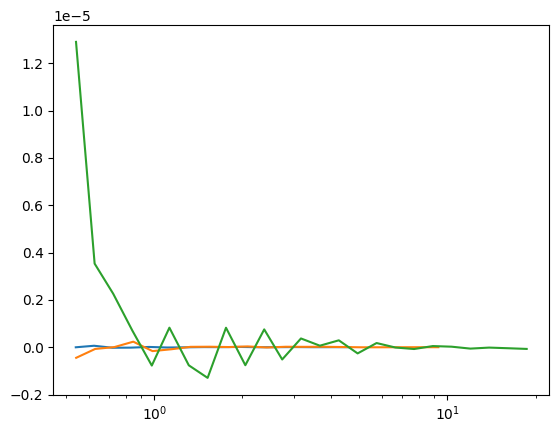

In [68]:
for i in range(3):
    plt.semilogx(threepcfs[i].bin_centers[0], np.diag(threepcfs[i].npcf[0,0,...,15]))

/tmp/ipykernel_201920/3721932938.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(threepcfs[5].npcf_multipoles_norm[0,0].real))


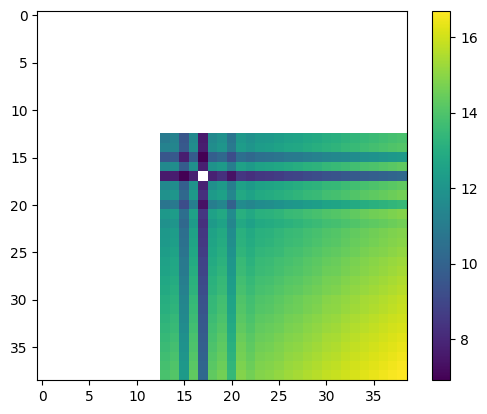

In [83]:
plt.imshow(np.log10(threepcfs[5].npcf_multipoles_norm[0,0].real))
plt.colorbar()

/tmp/ipykernel_201920/821645978.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(threepcfs[2].npcf_multipoles[0,0,0].real))


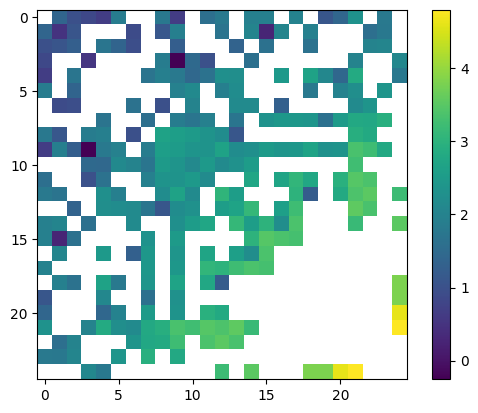

In [108]:
plt.imshow(np.log10(threepcfs[2].npcf_multipoles[0,0,0].real))
plt.colorbar()

In [96]:
import fftnpcf

In [134]:
fftnpcfcat = fftnpcf.PolarCatalog(pos1=slicsfullreso.pos1[::10], pos2=slicsfullreso.pos2[::10],
                                  e1=slicsfullreso.tracer_1[::10], e2=slicsfullreso.tracer_2[::10], 
                                  weight=np.ones(len(slicsfullreso.tracer_2[::10])))

In [136]:
%%time
fftnpcfcat.build_pixeltable_c()
fftres = fftnpcfcat.get_Gammans_discrete(nmax=30,rmin=0.5,rmax=50.,nbinsr=20,nthreads=16)

0.00030817464 0.00094911078 599.99701 599.99768
-0.99969182536 -0.99905088922 600.99701 600.99768
601 601 1.0016584056994342 1.0016584540586022
CPU times: user 25min 36s, sys: 1.41 s, total: 25min 38s
Wall time: 1min 42s


In [142]:
bin_edges_fft, bin_centers_fft, threepcfs_n_fft, threepcfsnorm_n_fft = fftres

/tmp/ipykernel_201920/4195049530.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(threepcfs_n_fft[2,10,0].real/threepcfsdisc.npcf_multipoles[2,10,0].real))


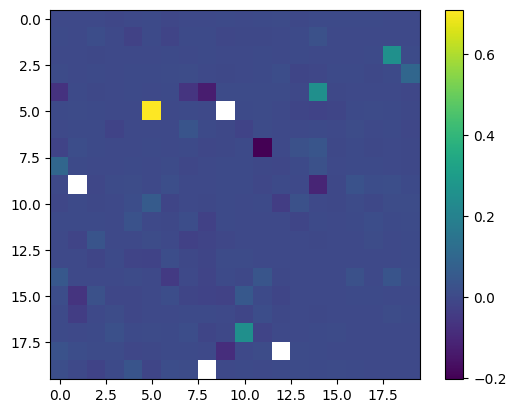

In [147]:
plt.imshow(np.log10(threepcfs_n_fft[2,10,0].real/threepcfsdisc.npcf_multipoles[2,10,0].real))
plt.colorbar()

[2 2 2]
Do we add
We add
0.00030817464 0.00094911078 599.99701 599.99768
-4.99969182536 -4.99905088922 604.99701 604.99768
121 121 5.041295056407934 5.041295296605123
CPU times: user 25min 30s, sys: 1.81 s, total: 25min 31s
Wall time: 1min 44s


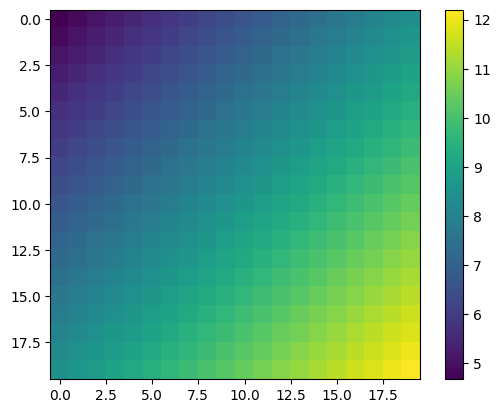

In [171]:
plt.imshow(np.log10(np.abs(threepcfsdisc.npcf_multipoles_norm[0,0].real)))
plt.colorbar()

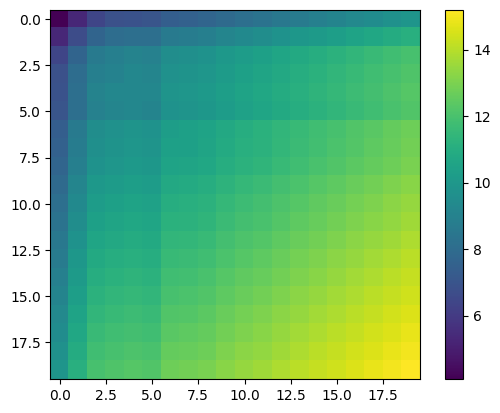

In [172]:
plt.imshow(np.log10(np.abs(threepcf_d1p0.npcf_multipoles_norm[0,0].real)))
plt.colorbar()

In [2]:
data = Table.read("/cosma7/data/dp004/dc-port3/Data/SLICS/KiDS450/GalCatalog_LOS1.fits")
pos1 = data["x_arcmin"].data
pos2 = data["y_arcmin"].data
gamma1 = data["shear1"].data
gamma2 = data["shear2"].data
e1 = data["eps_obs1"].data
e2 = data["eps_obs2"].data
zspec = data["z_spectroscopic"].data
zphot = data["z_photometric"].data

In [3]:
slicsfullreso = orpheus.SpinTracerCatalog(spin=2, pos1=pos1, pos2=pos2, tracer_1=gamma1, tracer_2=gamma2, zbins=None)
slicsthinned10 = orpheus.SpinTracerCatalog(spin=2, pos1=pos1[::10], pos2=pos2[::10], tracer_1=gamma1[::10], tracer_2=gamma2[::10], zbins=None)

In [30]:
%%time
threepcf_full = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=8., nbinsr=20, method="Discrete")
threepcf_full.process(slicsfullreso, nthreads=16)
threepcf_full.multipoles2npcf()

[2 2 2]
CPU times: user 1h 34min 11s, sys: 5.39 s, total: 1h 34min 17s
Wall time: 6min 3s


In [31]:
%%time
slics_d0p25 = slicsfullreso.reduce(0.25, ret_inst=True)
#slics_d0p25.tracer_1 *= np.sum(slics_d0p25.weight*slics_d0p25.tracer_1)/np.sum(slicsfullreso.weight*slicsfullreso.tracer_1)
#slics_d0p25.tracer_2 *= np.sum(slics_d0p25.weight*slics_d0p25.tracer_2)/np.sum(slicsfullreso.weight*slicsfullreso.tracer_2)
threepcf_d0p25 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=16., nbinsr=25, method="Discrete")
threepcf_d0p25.process(slics_d0p25, nthreads=16)
threepcf_d0p25.multipoles2npcf()

[2 2 2]
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-0.999989662319 -0.999951384962 600.99976 600.99988
601 601 1.0016634769755723 1.0016636129533476
CPU times: user 2h 41min 39s, sys: 3.77 s, total: 2h 41min 43s
Wall time: 10min 33s


In [32]:
%%time
slics_d0p5 = slicsfullreso.reduce(0.5, ret_inst=True)
threepcf_d0p5 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=32., nbinsr=30, method="Discrete")
threepcf_d0p5.process(slics_d0p5, nthreads=16)
threepcf_d0p5.multipoles2npcf()

[2 2 2]
1.0337681e-05 0.00024391338 599.99664 599.99756
-2.999989662319 -2.99975608662 602.99664 602.99756
201 201 3.014908605285169 3.014912020331443
CPU times: user 2h 52min 49s, sys: 2.87 s, total: 2h 52min 52s
Wall time: 11min 25s


In [33]:
%%time
slics_d1p0 = slicsfullreso.reduce(1., ret_inst=True)
threepcf_d1p0 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=64., nbinsr=35, method="Discrete")
threepcf_d1p0.process(slics_d1p0, nthreads=16)
threepcf_d1p0.multipoles2npcf()

[2 2 2]
0.19420601420000003 0.09920596979999999 599.7801175 599.814356
-5.8057939858 -5.9007940302 605.7801175 605.814356
101 101 6.055306054314852 6.056585643863366
CPU times: user 54min 41s, sys: 1.89 s, total: 54min 43s
Wall time: 3min 44s


In [34]:
%%time
slics_d2p0 = slicsfullreso.reduce(2., ret_inst=True)
threepcf_d2p0 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=128., nbinsr=40, method="Discrete")
threepcf_d2p0.process(slics_d2p0, nthreads=16)
threepcf_d2p0.multipoles2npcf()

[2 2 2]
0.6596817388529413 0.6683158212571428 599.2790366666666 599.2762194871794
-11.34031826114706 -11.331684178742858 611.2790366666666 611.2762194871794
51 51 12.208222645643405 12.207998111096517
0 [1 1 1 ... 1 1 1]
int32 <class 'numpy.ctypeslib.ndpointer_<i4_C_CONTIGUOUS'>
1 [31. 45. 31. ... 40. 30. 29.]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
2 [  1.03515269   0.96697369   1.11144583 ... 598.966434   599.139498
 599.14679966]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
3 [  1.12323301   3.05732211   4.9940349  ... 594.91386    596.8583
 599.09769897]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
4 [-0.00678948 -0.00799814 -0.01318982 ...  0.00465612 -0.00295668
  0.0032764 ]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
5 [ 0.0116347   0.01491831  0.00308049 ...  0.00285059 -0.01024731
 -0.01549553]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
6 [0 0 0 ... 0 0 0]
int32 <class 'numpy.ctypeslib.ndp

/cosma7/data/dp004/dc-port3/miniconda3/envs/3PointEnv/lib/python3.10/site-packages/orpheus/npcf.py:324: RuntimeWarning: divide by zero encountered in true_divide
  self.npcf[elm,...,elphi] = tmp/N0.real
/cosma7/data/dp004/dc-port3/miniconda3/envs/3PointEnv/lib/python3.10/site-packages/orpheus/npcf.py:324: RuntimeWarning: invalid value encountered in true_divide
  self.npcf[elm,...,elphi] = tmp/N0.real


CPU times: user 12min 23s, sys: 613 ms, total: 12min 24s
Wall time: 55.4 s


In [35]:
%%time
slics_d4p0 = slicsfullreso.reduce(4., ret_inst=True)
threepcf_d4p0 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=256., nbinsr=45, method="Discrete")
threepcf_d4p0.process(slics_d4p0, nthreads=16)
threepcf_d4p0.multipoles2npcf()

[2 2 2]
1.72225373948062 1.6784671895848 598.232623442623 598.3188340476191
-23.27774626051938 -23.3215328104152 623.232623442623 623.3188340476191
25 25 25.860414788125695 25.865614674321375
CPU times: user 3min 8s, sys: 529 ms, total: 3min 9s
Wall time: 15.7 s


178.20000000000002


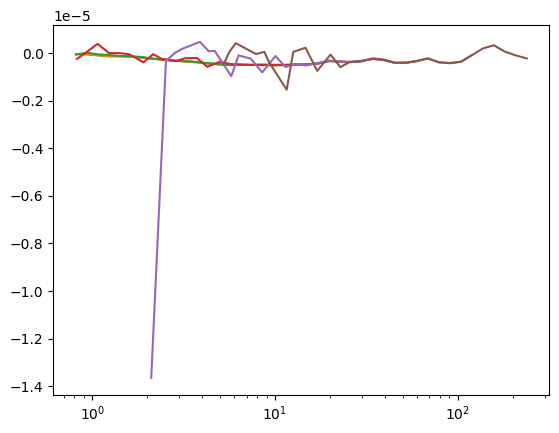

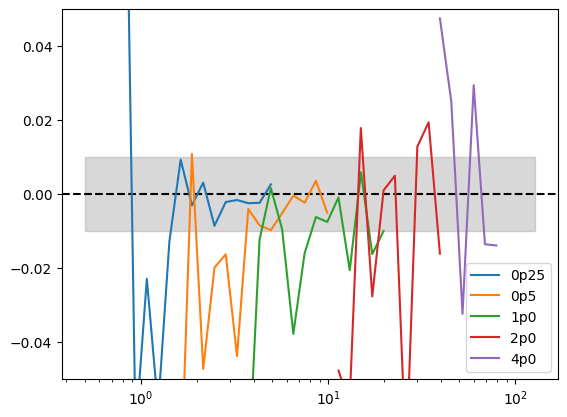

In [137]:
elcomp = 0
elphi = 49
cutlevel = 0.075
kdiag = 3
print(threepcf_d1p0.phi[elphi]*180/np.pi)

plt.semilogx(threepcf_full.bin_centers[0,kdiag:], threepcf_full.bin_centers[0,kdiag:]*np.diag(threepcf_full.npcf[elcomp,0,...,elphi],k=kdiag))
plt.semilogx(threepcf_d0p25.bin_centers[0,kdiag:], threepcf_d0p25.bin_centers[0,kdiag:]*np.diag(threepcf_d0p25.npcf[elcomp,0,...,elphi],k=kdiag))
plt.semilogx(threepcf_d0p5.bin_centers[0,kdiag:], threepcf_d0p5.bin_centers[0,kdiag:]*np.diag(threepcf_d0p5.npcf[elcomp,0,...,elphi],k=kdiag))
plt.semilogx(threepcf_d1p0.bin_centers[0,kdiag:], threepcf_d1p0.bin_centers[0,kdiag:]*np.diag(threepcf_d1p0.npcf[elcomp,0,...,elphi],k=kdiag))
plt.semilogx(threepcf_d2p0.bin_centers[0,kdiag:], threepcf_d2p0.bin_centers[0,kdiag:]*np.diag(threepcf_d2p0.npcf[elcomp,0,...,elphi],k=kdiag))
plt.semilogx(threepcf_d4p0.bin_centers[0,kdiag:], threepcf_d4p0.bin_centers[0,kdiag:]*np.diag(threepcf_d4p0.npcf[elcomp,0,...,elphi],k=kdiag))
plt.show()

plt.axhline(0, color="k", ls="--")
plt.fill_between(x=threepcf_d2p0.bin_edges, y1=-.01, y2=.01, color="grey", alpha=.3)
thisratio = np.diag(threepcf_d0p25.npcf[elcomp,0,...,elphi],k=kdiag)[:-5]/np.diag(threepcf_full.npcf[elcomp,0,...,elphi],k=kdiag)-1
cut = np.argwhere(np.abs(thisratio)>cutlevel)[-1][0]
plt.semilogx(threepcf_full.bin_centers[0][cut:-kdiag], thisratio[cut:], label="0p25")
thisratio = np.diag(threepcf_d0p5.npcf[elcomp,0,...,elphi],k=kdiag)[:-5]/np.diag(threepcf_d0p25.npcf[elcomp,0,...,elphi],k=kdiag)-1
cut = np.argwhere(np.abs(thisratio)>cutlevel)[-1][0]
plt.semilogx(threepcf_d0p25.bin_centers[0][cut:-kdiag], thisratio[cut:], label="0p5")
thisratio = np.diag(threepcf_d1p0.npcf[elcomp,0,...,elphi],k=kdiag)[:-5]/np.diag(threepcf_d0p5.npcf[elcomp,0,...,elphi],k=kdiag)-1
cut = np.argwhere(np.abs(thisratio)>cutlevel)[-1][0]
plt.semilogx(threepcf_d0p5.bin_centers[0][cut:-kdiag], thisratio[cut:], label="1p0")
thisratio = np.diag(threepcf_d2p0.npcf[elcomp,0,...,elphi],k=kdiag)[:-5]/np.diag(threepcf_d1p0.npcf[elcomp,0,...,elphi],k=kdiag)-1
cut = np.argwhere(np.abs(thisratio)>cutlevel)[-1][0]
plt.semilogx(threepcf_d1p0.bin_centers[0][cut:-kdiag], thisratio[cut:], label="2p0")
thisratio = np.diag(threepcf_d4p0.npcf[elcomp,0,...,elphi],k=kdiag)[:-5]/np.diag(threepcf_d2p0.npcf[elcomp,0,...,elphi],k=kdiag)-1
cut = np.argwhere(np.abs(thisratio)>cutlevel)[-1][0]
plt.semilogx(threepcf_d2p0.bin_centers[0][cut:-kdiag], thisratio[cut:], label="4p0")
plt.ylim(-.05,.05)
plt.legend()
plt.show()

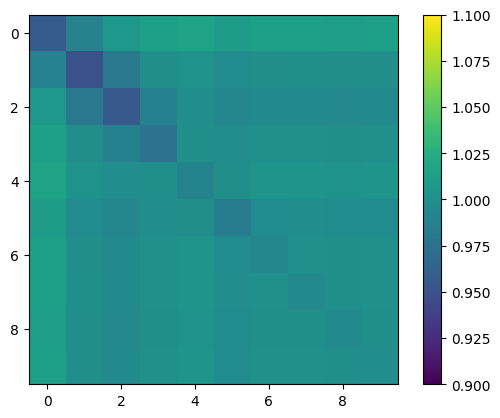

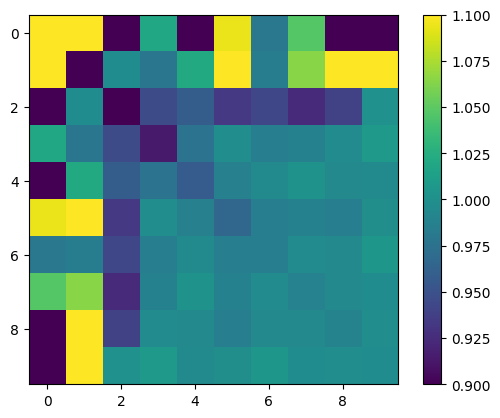

In [10]:
plt.imshow(threepcf_d0p25.npcf_multipoles_norm[0,0][:10,:10].real/threepcf_full.npcf_multipoles_norm[0,0].real,vmin=0.9,vmax=1.1)
plt.colorbar()
plt.show()

plt.imshow(threepcf_d0p25.npcf_multipoles[0,0,0][:10,:10].real/threepcf_full.npcf_multipoles[0,0,0].real,vmin=0.9,vmax=1.1)
plt.colorbar()
plt.show()

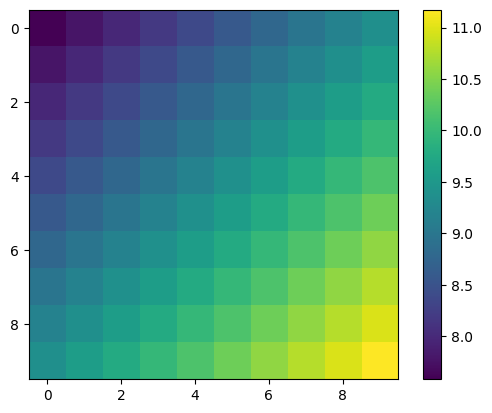

In [89]:
plt.imshow(np.log10(threepcf_full.npcf_multipoles_norm[0,0].real))
plt.colorbar()

In [18]:
threepcf_d4p0.bin_centers[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  3.87103811,  4.09434824,
        5.65846675,  7.83722533,  8.7147298 , 11.8259409 , 13.74058609,
       17.28763266, 22.13302848, 28.2060673 , 35.50357522, 44.8460354 ])

In [25]:
threepcf_d0p5.bin_edges

NameError: name 'threepcf_d0p5' is not defined

In [117]:
np.diag(threepcf_full.npcf[elcomp,0,...,elphi],k=8)

array([6.65885882e-08+5.06402684e-09j, 8.28094830e-08+8.82534972e-09j,
       8.81910696e-08+1.74404298e-08j, 1.05019446e-07+5.01500711e-09j,
       1.04275630e-07+6.79380093e-09j, 1.02444406e-07+6.81097791e-09j,
       1.05478312e-07+5.45027718e-09j, 1.09731088e-07+1.05388800e-08j,
       1.08288919e-07+1.02297665e-08j, 1.04024948e-07+6.82043915e-09j,
       1.01768209e-07+9.47293177e-09j, 9.52020846e-08+7.01741205e-09j])

In [118]:
np.diag(threepcf_d0p25.npcf[elcomp,0,...,elphi],k=8)[:-5]

array([5.17523637e-08+2.37071961e-08j, 6.63002132e-08+1.49515972e-08j,
       1.05063027e-07+2.27903133e-08j, 1.01625817e-07+1.49953592e-08j,
       1.00097690e-07+2.08403715e-09j, 1.00137723e-07+4.74362244e-09j,
       1.05325802e-07+8.81391322e-09j, 1.10152821e-07+1.10315970e-08j,
       1.06804617e-07+9.97286179e-09j, 1.02633002e-07+6.89612705e-09j,
       1.02087210e-07+9.42040109e-09j, 9.46544145e-08+7.01281069e-09j])

In [12]:
np.sum(slicsfullreso.weight)

3070801.0

In [13]:
np.sum(slics_d0p25.weight)

3070801.0

In [154]:
np.sum(slics_d0p25.tracer_2)*3070801.0/2380245

557.4240684339396

In [24]:
np.sum(slicsfullreso.tracer_1)/np.sum(slicsfullreso.weight)

-0.0007747825595844516

In [23]:
np.sum(slics_d0p25.weight*slics_d0p25.tracer_1)/np.sum(slics_d0p25.weight)

-0.0011767495852690948

In [36]:
slicsfullreso.nbinsz

1

In [170]:
dpixs = [0.25,0.5,1.]
slicshash = slicsfullreso.multihash(dpixs=dpixs,tomo=False)

1.0337681e-05 4.8615038e-05 599.99976 599.99988
-1.9999896623189999 -1.9999513849619999 601.99976 601.99988
603 603 1.0016579596390034 1.0016580951657743
0.25 3070801
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-1.9999896623189999 -1.9999513849619999 601.99976 601.99988
603 603 1.0016579596390034 1.0016580951657743
0.5 3070801
1.0337681e-05 0.00024391338 599.99664 599.99756
-1.9999896623189999 -1.9999513849619999 601.99976 601.99988
603 603 1.0016579596390034 1.0016580951657743
1.0 3070801
0.19420601420000003 0.09920596979999999 599.7801175 599.814356
-1.9999896623189999 -1.9999513849619999 601.99976 601.99988
603 603 1.0016579596390034 1.0016580951657743


In [173]:
ngals, pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals = slicshash

In [152]:
for i in range(4):
    print(len(pos1s[i]), len(pix_gals[i]), len(index_matchers[i]), len(pixs_galind_bounds[i]))

3070801 3070801 363609 3070802
2380245 2380245 363609 2380246
1269041 1269041 363609 1269042
359922 359922 363609 359923


In [162]:
slicsfullreso.pix1_n*slicsfullreso.pix1_n

363609

In [193]:
np.concatenate([allfields[i][0] for i in range(len(allfields))])

array([2.38873890e-06, 9.01606020e-06, 2.93215020e-05, ...,
       6.88890763e-03, 1.91606691e-03, 6.93463917e-03])

In [181]:
allpos1 = np.array([])
for eld in range(len(pos1s)):
    allpos1 = np.append(allpos1, pos1s[eld])
len(allpos1)

7080009

In [186]:
arr1 = np.arange(5)
arr2 = np.arange(4)
arr3 = np.arange(6)
np.concatenate([arr1, arr2, arr3])
#([array1, array2])

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 0, 1, 2, 3, 4, 5])

In [6]:
threepcf_fulltree.tree_redges

array([ 0.5,  5. , 10. , 20. , 40. , 64. ])

In [5]:
threepcf_fulltree.tree_resos

array([0.  , 0.25, 0.5 , 1.  , 2.  ])

In [61]:
#threepcf_fulltree = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=64., nbinsr=35, method="Tree")
threepcf_fulltree10 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=64., nbinsr=35, rmin_pixsize=10, method="Tree")
threepcf_fulltree10.tree_redges

[2 2 2]


array([ 0.5,  2.5,  5. , 10. , 20. , 64. ])

In [ ]:
threepcf_fulltree.process(slicsfullreso, nthreads=16)

1.0337681e-05 4.8615038e-05 599.99976 599.99988
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
0.25 3070801
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
0.5 3070801
1.0337681e-05 0.00024391338 599.99664 599.99756
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
1.0 3070801
0.19420601420000003 0.09920596979999999 599.7801175 599.814356
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
2.0 3070801
0.6596817388529413 0.6683158212571428 599.2790366666666 599.2762194871794
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732


In [31]:
threepcf_fulltree.multipoles2npcf()

In [62]:
%%time
threepcf_fulltree10.process(slicsfullreso, nthreads=16)
threepcf_fulltree10.multipoles2npcf()

1.0337681e-05 4.8615038e-05 599.99976 599.99988
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
0.25 3070801
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
0.5 3070801
1.0337681e-05 0.00024391338 599.99664 599.99756
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
1.0 3070801
0.19420601420000003 0.09920596979999999 599.7801175 599.814356
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
2.0 3070801
0.6596817388529413 0.6683158212571428 599.2790366666666 599.2762194871794
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
CPU times: user 4h 59s, sys: 5.15 s, total: 4h 1min 4s
Wall time: 16min 4s


In [81]:
%%time
threepcf_fulltree30 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=64., nbinsr=35, rmin_pixsize=30, method="Tree")
threepcf_fulltree30.tree_redges
threepcf_fulltree30.process(slicsfullreso, nthreads=16)
threepcf_fulltree30.multipoles2npcf()

[2 2 2]
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
0.25 3070801
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
0.5 3070801
1.0337681e-05 0.00024391338 599.99664 599.99756
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
1.0 3070801
0.19420601420000003 0.09920596979999999 599.7801175 599.814356
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
2.0 3070801
0.6596817388529413 0.6683158212571428 599.2790366666666 599.2762194871794
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
CPU times: user 13h 35min 10s, sys: 16 s, total: 13h 35min 26s
Wall time: 54min 9s


In [152]:
print(threepcf_fulltree.tree_redges)
print(threepcf_fulltree.tree_resos)

[ 0.5  5.  10.  20.  40.  64. ]
[0.   0.25 0.5  1.   2.  ]


In [ ]:
%%time
threepcf_fulltree20_dmax4 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=64., nbinsr=35, rmin_pixsize=30, method="Tree")
threepcf_fulltree20_dmax4.tree_redges
threepcf_fulltree20_dmax4.process(slicsfullreso, nthreads=16)
threepcf_fulltree20_dmax4.multipoles2npcf()

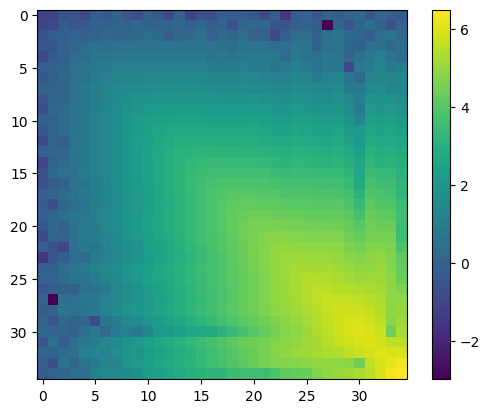

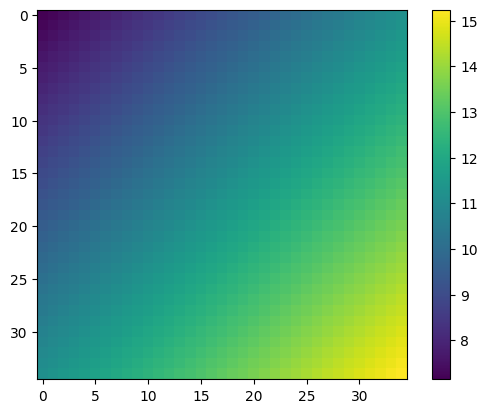

In [30]:
plt.imshow(np.log10(np.abs(threepcf_fulltree.npcf_multipoles[0,0,0].real)))
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(threepcf_fulltree.npcf_multipoles_norm[0,0].real)))
plt.colorbar()
plt.show()

0.5380251177694896 0.5380251177694896 0.016901862493067493 1.8000000000000003


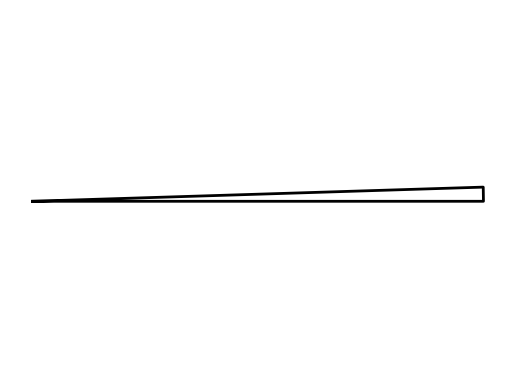

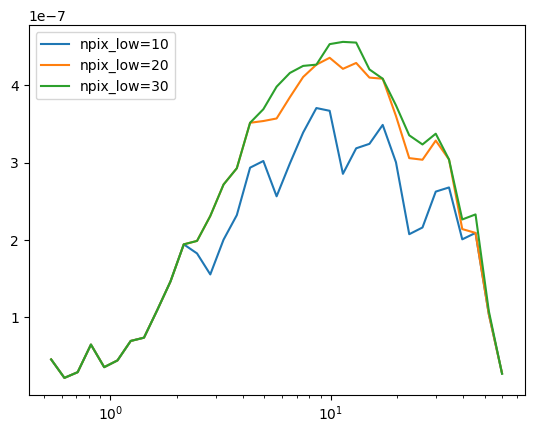

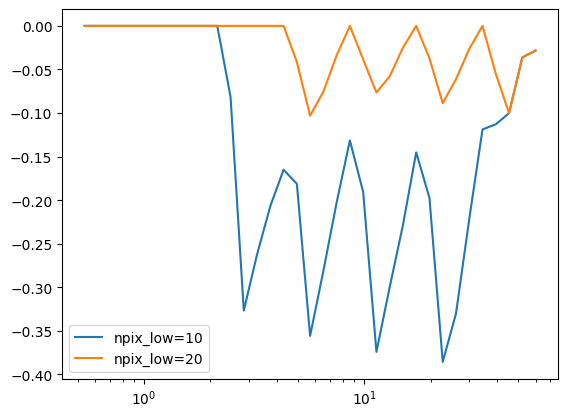

In [148]:
elcomp = 0
elphi = 0
k = 0

side1 = threepcf_fulltree.bin_centers[0][k]
side2 = threepcf_fulltree.bin_centers[0][0]
angle = threepcf_fulltree.phi[elphi]
side3 = np.sqrt(side1**2 + side2**2 - 2 * side1 * side2 * np.cos(angle))
print(side1, side2, side3, angle*180/np.pi)
angle_A = np.degrees(np.arcsin(side1 * np.sin(angle) / side3))
angle_B = np.degrees(np.arcsin(side2 * np.sin(angle) / side3))
A = np.array([0, 0])
B = np.array([side1, 0])
C = np.array([side2 * np.cos(angle), side2 * np.sin(angle)])
plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'k-', linewidth=2)  # Triangle sides
plt.axis('equal')
plt.axis("off")
plt.show()

_centers = threepcf_fulltree.bin_centers[0][k:]
plt.semilogx(_centers, _centers*np.diag(threepcf_fulltree10.npcf[elcomp,0,...,elphi],k=k), label="npix_low=10")
plt.semilogx(_centers, _centers*np.diag(threepcf_fulltree.npcf[elcomp,0,...,elphi],k=k), label="npix_low=20")
plt.semilogx(_centers, _centers*np.diag(threepcf_fulltree30.npcf[elcomp,0,...,elphi],k=k), label="npix_low=30")
plt.legend()
plt.show()

plt.semilogx(_centers, np.diag((threepcf_fulltree10.npcf/threepcf_fulltree30.npcf)[elcomp,0,...,elphi],k=k)-1, label="npix_low=10")
plt.semilogx(_centers, np.diag((threepcf_fulltree.npcf/threepcf_fulltree30.npcf)[elcomp,0,...,elphi],k=k)-1, label="npix_low=20")
plt.legend()
plt.show()

In [ ]:
def pickle_load(fname):
    with open(fname, 'rb') as handle:
        res = pickle.load(handle)
    return res

In [121]:
data1 = pickle_load("../data/ResoTest_SLICSNoiseless_discrete_reduced1p0")
data2 = pickle_load("../data/ResoTest_SLICSNoiseless_discrete_reduced2p0")
data4 = pickle_load("../data/ResoTest_SLICSNoiseless_discrete_reduced4p0")
data8 = pickle_load("../data/ResoTest_SLICSNoiseless_discrete_reduced8p0")
data1shuff = pickle_load("../data/ResoTest_SLICSNoiseless_discrete_reduced_shuffled1p0")
data2shuff = pickle_load("../data/ResoTest_SLICSNoiseless_discrete_reduced_shuffled2p0")
data4shuff = pickle_load("../data/ResoTest_SLICSNoiseless_discrete_reduced_shuffled4p0")
treedata5 = pickle_load("../data/ResoTest_SLICSNoiseless_tree_rminpixsizes5")
treedata10 = pickle_load("../data/ResoTest_SLICSNoiseless_tree_rminpixsizes10")
treedata20 = pickle_load("../data/ResoTest_SLICSNoiseless_tree_rminpixsizes20")
treedata30 = pickle_load("../data/ResoTest_SLICSNoiseless_tree_rminpixsizes30")
treedata40 = pickle_load("../data/ResoTest_SLICSNoiseless_tree_rminpixsizes40")
discdata = pickle_load("../data/ResoTest_SLICSNoiseless_discrete_fullcat")

In [254]:
angle

0.031415926535897934

0.3317597802843467 0.2764245797824564 0.07293904458903704 9.0


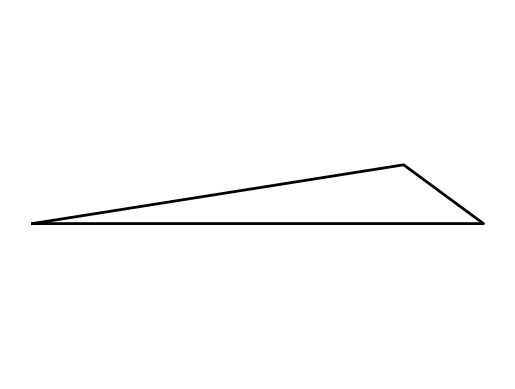

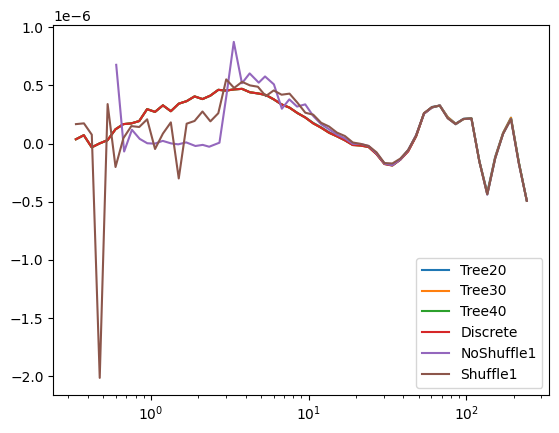

In [39]:
elcomp = 1
elphi1 = 2
elphi2 = 3
k = 2

side1 = data1["Pars"]["bin_centers"][0][k]
side2 = data1["Pars"]["bin_centers"][0][0]
_angle = np.linspace(0,2*np.pi,101) 
angle = .5*(_angle[1:]+_angle[:-1])[elphi1]
side3 = np.sqrt(side1**2 + side2**2 - 2 * side1 * side2 * np.cos(angle))
print(side1, side2, side3, angle*180/np.pi)
angle_A = np.degrees(np.arcsin(side1 * np.sin(angle) / side3))
angle_B = np.degrees(np.arcsin(side2 * np.sin(angle) / side3))
A = np.array([0, 0])
B = np.array([side1, 0])
C = np.array([side2 * np.cos(angle), side2 * np.sin(angle)])
plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'k-', linewidth=2)  # Triangle sides
plt.axis('equal')
plt.axis("off")
plt.show()

#plt.semilogx(treedata5["Pars"]["bin_centers"][0][k:], treedata5["Pars"]["bin_centers"][0][k:]*
#             np.diag(np.mean(treedata5["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="Tree5")
#plt.semilogx(treedata10["Pars"]["bin_centers"][0][k:], treedata10["Pars"]["bin_centers"][0][k:]*
#             np.diag(np.mean(treedata10["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="Tree10")
plt.semilogx(treedata20["Pars"]["bin_centers"][0][k:], treedata20["Pars"]["bin_centers"][0][k:]*
             np.diag(np.mean(treedata20["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="Tree20")
plt.semilogx(treedata30["Pars"]["bin_centers"][0][k:], treedata30["Pars"]["bin_centers"][0][k:]*
             np.diag(np.mean(treedata30["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="Tree30")
plt.semilogx(treedata40["Pars"]["bin_centers"][0][k:], treedata40["Pars"]["bin_centers"][0][k:]*
             np.diag(np.mean(treedata40["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="Tree40")
plt.semilogx(discdata["Pars"]["bin_centers"][0][k:], discdata["Pars"]["bin_centers"][0][k:]*
             np.diag(np.mean(discdata["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="Discrete")
plt.semilogx(data1["Pars"]["bin_centers"][0][k:], data1["Pars"]["bin_centers"][0][k:]*
             np.diag(np.mean(data1["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="NoShuffle1")
#plt.semilogx(data2["Pars"]["bin_centers"][0][k:], data2["Pars"]["bin_centers"][0][k:]*
#             np.diag(np.mean(data2["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="NoShuffle2")
#plt.semilogx(data4["Pars"]["bin_centers"][0][k:], data4["Pars"]["bin_centers"][0][k:]*
#             np.diag(np.mean(data4["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="NoShuffle4")
#plt.semilogx(data8["Pars"]["bin_centers"][0][k:], data8["Pars"]["bin_centers"][0][k:]*
#             np.diag(np.mean(data8["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="NoShuffle8")
plt.semilogx(data1shuff["Pars"]["bin_centers"][0][k:], data1shuff["Pars"]["bin_centers"][0][k:]*
             np.diag(np.mean(data1shuff["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="Shuffle1")
#plt.semilogx(data2shuff["Pars"]["bin_centers"][0][k:], data2shuff["Pars"]["bin_centers"][0][k:]*
#             np.diag(np.mean(data2shuff["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="Shuffle2")
#plt.semilogx(data4shuff["Pars"]["bin_centers"][0][k:], data4shuff["Pars"]["bin_centers"][0][k:]*
#             np.diag(np.mean(data4shuff["NPCF"][elcomp,0,...,elphi1:elphi2],axis=-1), k=k).real, label="Shuffle4")
plt.legend()
plt.show()


#treedata5["Ntriangles"]

In [201]:
print(data8["Time"])
print(data4["Time"], data4shuff["Time"])
print(data2["Time"], data2shuff["Time"])
print(data1["Time"], data1shuff["Time"])
print(treedata5["Time"])
print(treedata10["Time"])
print(treedata20["Time"])
print(treedata30["Time"])
print(treedata40["Time"])
print(discdata["Time"])

10.525709390640259
52.57140493392944 54.90247941017151
506.3917496204376 521.7671101093292
6801.3163142204285 6798.360777378082
7108.737375020981
7883.722671747208
10453.02242231369
15096.851676940918
21025.094475507736
38197.10247731209


In [17]:
reduced_resos = [8.0,4.0,2.0,1.0,0.5,0.25]
str_resos = ["8p0", "4p0", "2p0", "1p0", "0p5", "0p25"]
for elreso, reduced_reso in enumerate(reduced_resos):
    fname_save = "ResoTest_SLICSNoiseless_discrete_reduced%s"%str_resos[elreso]
    t1 = time()
    slics_reduced = slicsfullreso.reduce(reduced_reso, ret_inst=True)
    print(slicsfullreso.ngal, slics_reduced.ngal, slicsfullreso.ngal/slics_reduced.ngal)

3070801 5625 545.9201777777778
3070801 22500 136.48004444444445
3070801 90000 34.12001111111111
3070801 359922 8.531851345569319
3070801 1269041 2.4197807635844706
3070801 2380245 1.2901197145671979


/tmp/ipykernel_75866/3531455599.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(data2shuff["Norm"])[nmulti,0].real),vmin=0)


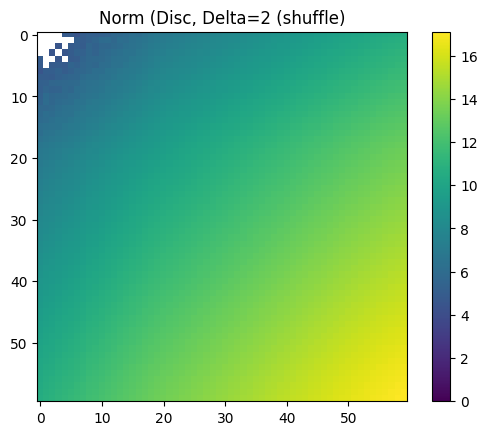

/tmp/ipykernel_75866/3531455599.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(data2shuff["Upsilon"])[elcomp,nmulti,0].real),vmin=0)


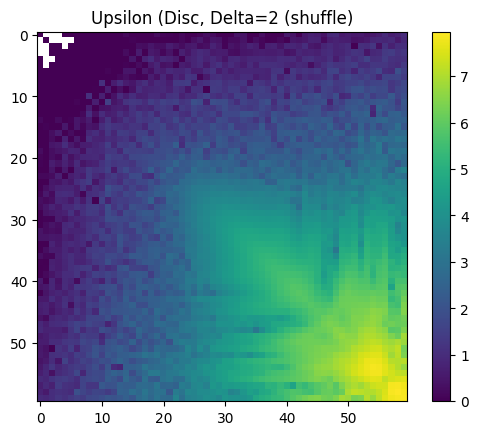

/tmp/ipykernel_75866/3531455599.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(data2["Norm"])[nmulti,0].real),vmin=0)


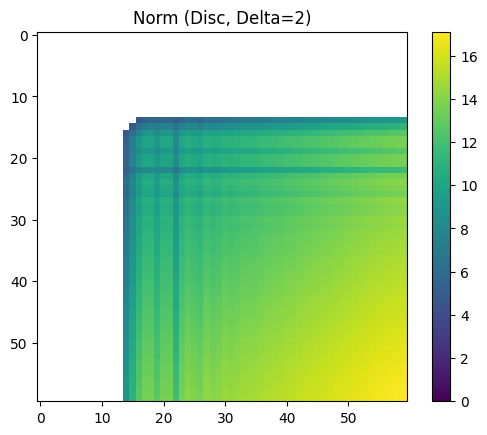

/tmp/ipykernel_75866/3531455599.py:19: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(data2["Upsilon"])[elcomp,nmulti,0].real),vmin=0)


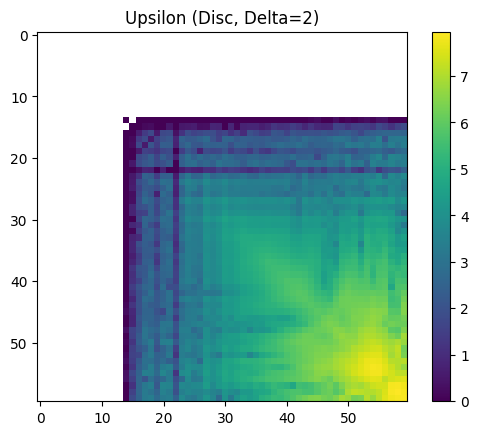

/tmp/ipykernel_75866/3531455599.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(data1["Norm"])[nmulti,0].real),vmin=0)


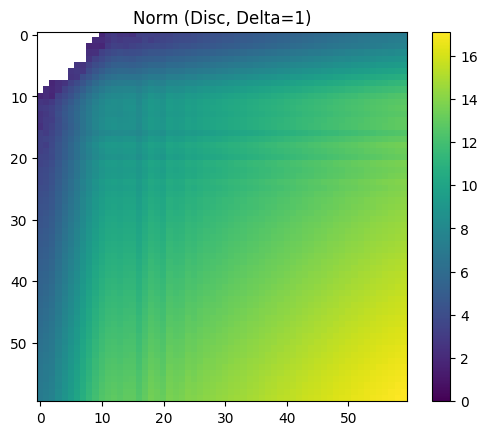

/tmp/ipykernel_75866/3531455599.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(data1["Upsilon"])[elcomp,nmulti,0].real),vmin=0)


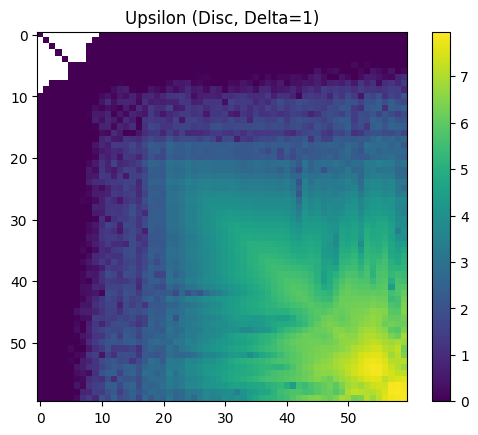

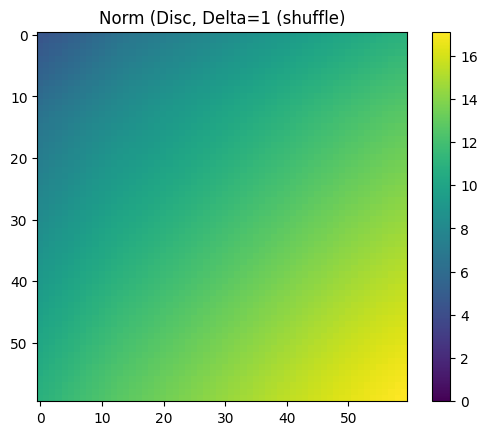

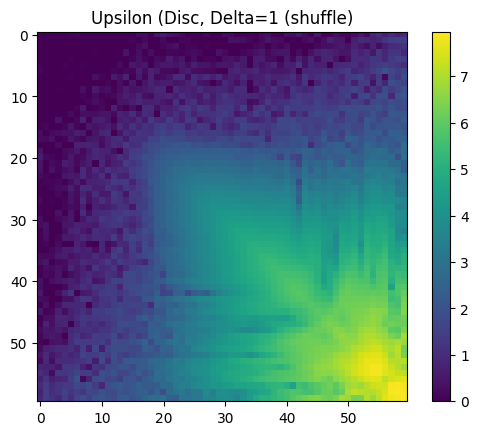

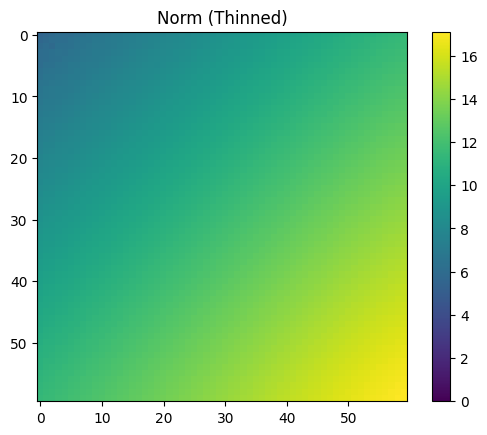

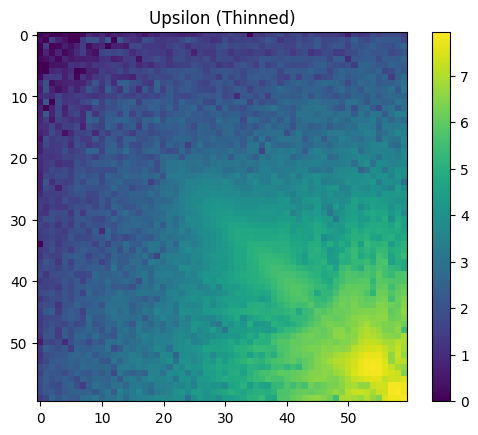

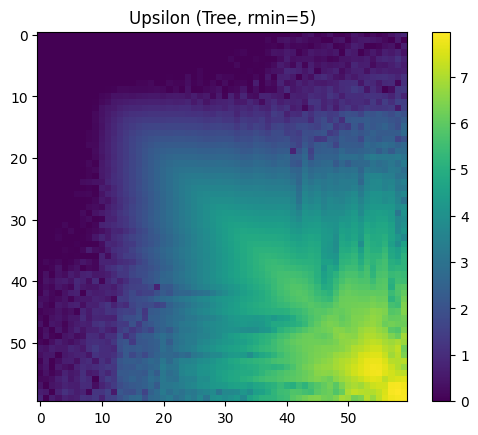

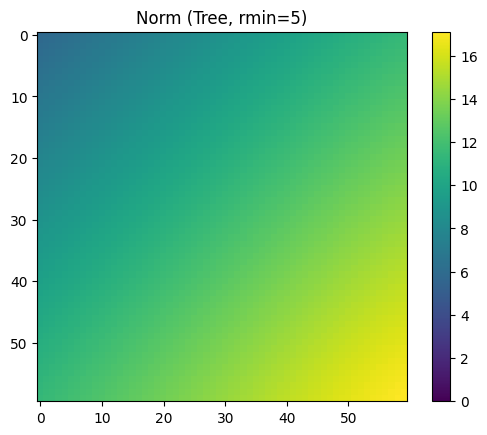

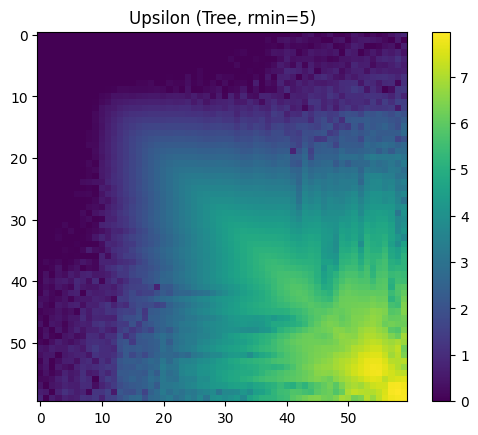

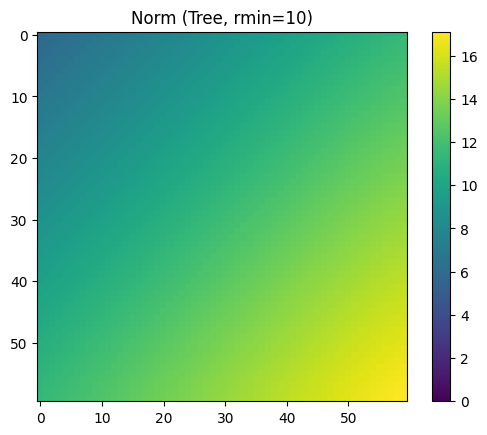

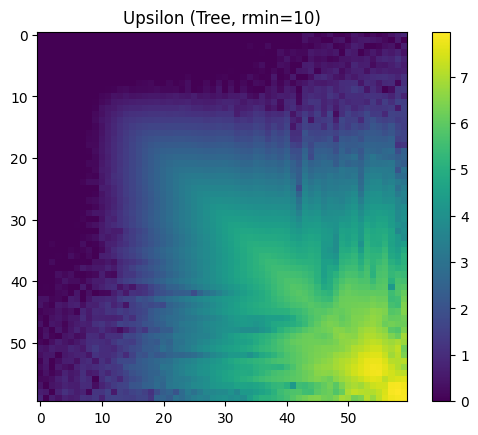

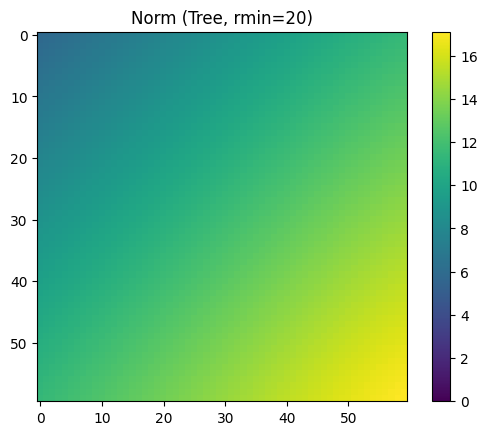

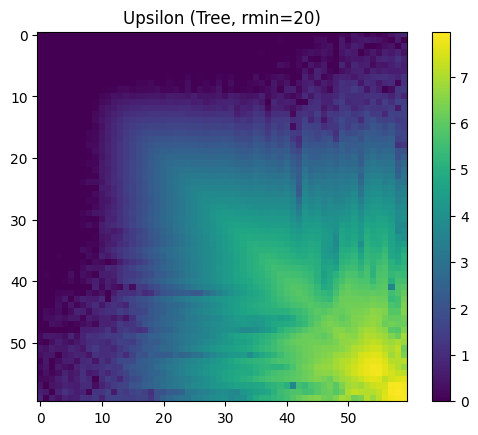

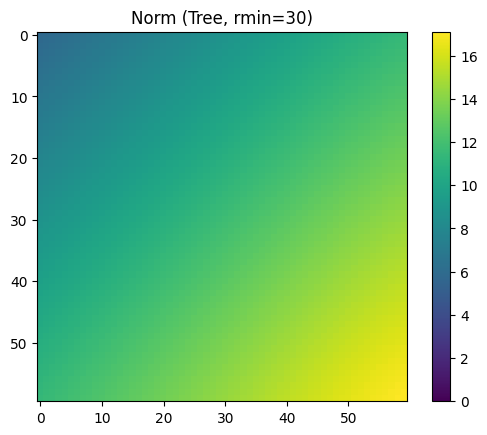

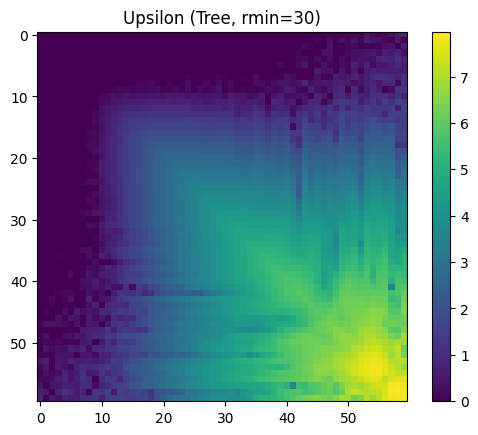

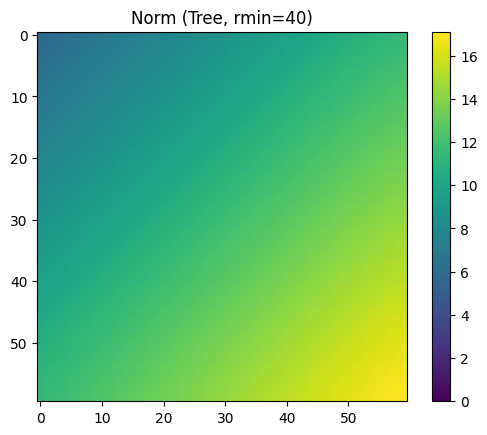

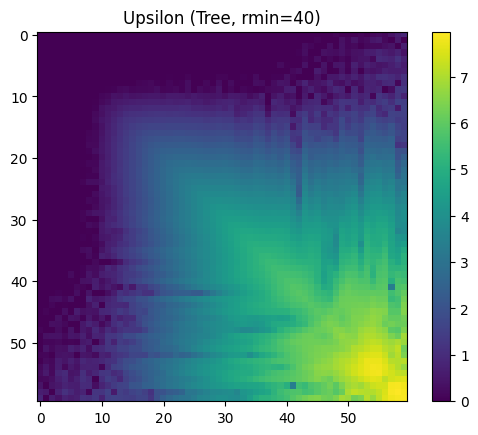

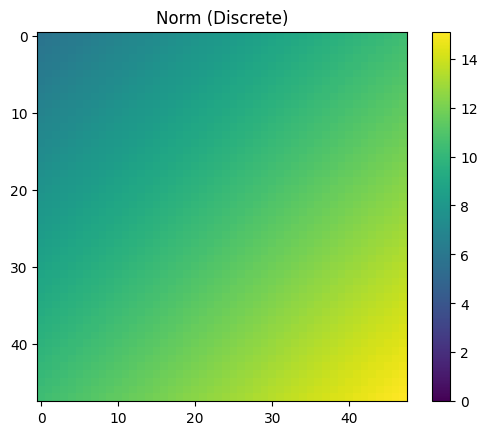

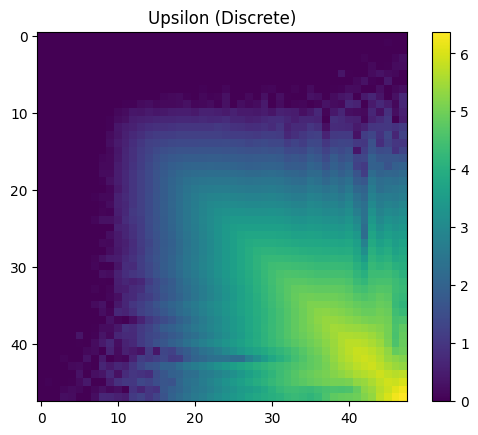

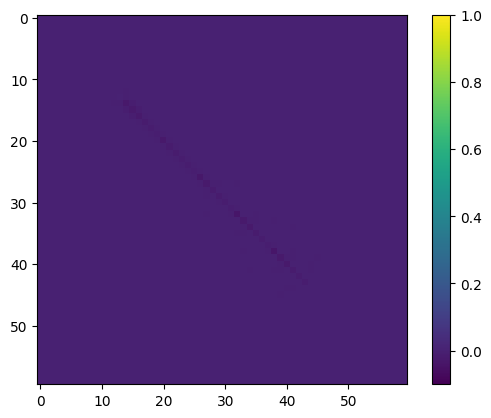

In [163]:
nmulti = 0
elcomp = 0

plt.imshow(np.log10(np.abs(data2shuff["Norm"])[nmulti,0].real),vmin=0)
plt.title("Norm (Disc, Delta=2 (shuffle)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(data2shuff["Upsilon"])[elcomp,nmulti,0].real),vmin=0)
plt.title("Upsilon (Disc, Delta=2 (shuffle)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(data2["Norm"])[nmulti,0].real),vmin=0)
plt.title("Norm (Disc, Delta=2)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(data2["Upsilon"])[elcomp,nmulti,0].real),vmin=0)
plt.title("Upsilon (Disc, Delta=2)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(data1["Norm"])[nmulti,0].real),vmin=0)
plt.title("Norm (Disc, Delta=1)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(data1["Upsilon"])[elcomp,nmulti,0].real),vmin=0)
plt.title("Upsilon (Disc, Delta=1)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(data1shuff["Norm"])[nmulti,0].real),vmin=0)
plt.title("Norm (Disc, Delta=1 (shuffle)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(data1shuff["Upsilon"])[elcomp,nmulti,0].real),vmin=0)
plt.title("Upsilon (Disc, Delta=1 (shuffle)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(threepcf_thinned.npcf_multipoles_norm)[nmulti,0].real,vmin=0)
plt.title("Norm (Thinned)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(threepcf_thinned.npcf_multipoles)[elcomp, nmulti,0].real,vmin=0)
plt.title("Upsilon (Thinned)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(treedata5["Upsilon"])[elcomp,nmulti,0].real,vmin=0)
plt.title("Upsilon (Tree, rmin=5)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(treedata5["Norm"])[nmulti,0].real,vmin=0)
plt.title("Norm (Tree, rmin=5)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(treedata5["Upsilon"])[elcomp,nmulti,0].real,vmin=0)
plt.title("Upsilon (Tree, rmin=5)")
plt.colorbar()
plt.show()


plt.imshow(np.log10(treedata10["Norm"])[nmulti,0].real,vmin=0)
plt.title("Norm (Tree, rmin=10)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(treedata10["Upsilon"])[elcomp,nmulti,0].real),vmin=0)
plt.title("Upsilon (Tree, rmin=10)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(treedata20["Norm"])[nmulti,0].real,vmin=0)
plt.title("Norm (Tree, rmin=20)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(treedata20["Upsilon"])[elcomp,nmulti,0].real),vmin=0)
plt.title("Upsilon (Tree, rmin=20)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(treedata30["Norm"])[nmulti,0].real,vmin=0,interpolation=None)
plt.title("Norm (Tree, rmin=30)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(treedata30["Upsilon"])[elcomp,nmulti,0].real),vmin=0,interpolation=None)
plt.title("Upsilon (Tree, rmin=30)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(treedata40["Norm"])[nmulti,0].real,vmin=0,interpolation=None)
plt.title("Norm (Tree, rmin=40)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(treedata40["Upsilon"])[elcomp,nmulti,0].real),vmin=0,interpolation=None)
plt.title("Upsilon (Tree, rmin=40)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(discdata["Norm"])[nmulti,0].real,vmin=0,interpolation=None)
plt.title("Norm (Discrete)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(discdata["Upsilon"])[elcomp,nmulti,0].real),vmin=0,interpolation=None)
plt.title("Upsilon (Discrete)")
plt.colorbar()
plt.show()


plt.imshow((treedata5["Norm"]/treedata10["Norm"])[nmulti,0].real-1,vmin=-.1,vmax=1)
plt.colorbar()
plt.show()

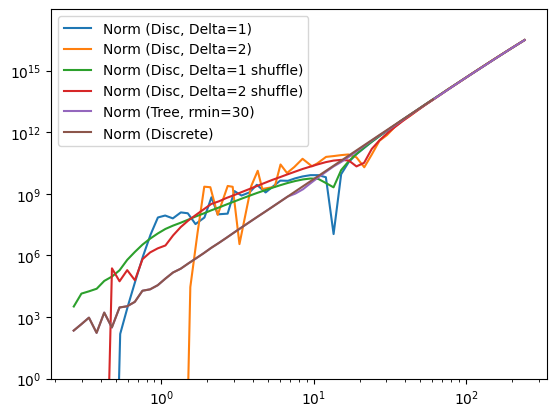

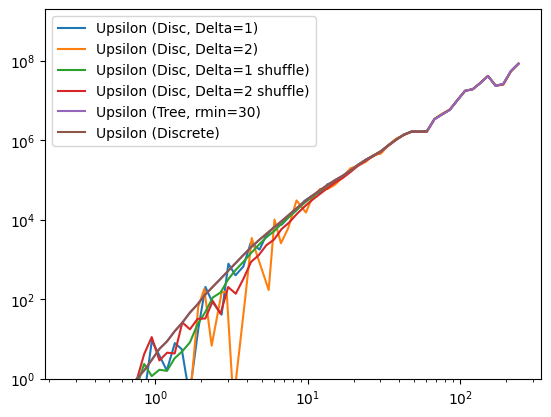

In [139]:
nmulti = 1
elcomp = 0
k=0

plt.loglog(data1["Pars"]["bin_centers"][0][k:], np.diag(np.abs(data1["Norm"])[nmulti,0].real)[k:],label="Norm (Disc, Delta=1)")
plt.loglog(data2["Pars"]["bin_centers"][0][k:], np.diag(np.abs(data2["Norm"])[nmulti,0].real)[k:],label="Norm (Disc, Delta=2)")
plt.loglog(data1shuff["Pars"]["bin_centers"][0][k:], np.diag(np.abs(data1shuff["Norm"])[nmulti,0].real)[k:],label="Norm (Disc, Delta=1 shuffle)")
plt.loglog(data2shuff["Pars"]["bin_centers"][0][k:], np.diag(np.abs(data2shuff["Norm"])[nmulti,0].real)[k:],label="Norm (Disc, Delta=2 shuffle)")
#plt.loglog(treedata5["Pars"]["bin_centers"][0][k:], np.diag(np.abs(treedata5["Norm"])[nmulti,0].real)[k:],label="Norm (Tree, rmin=5)")
#plt.loglog(treedata10["Pars"]["bin_centers"][0][k:], np.diag(np.abs(treedata10["Norm"])[nmulti,0].real)[k:],label="Norm (Tree, rmin=10)")
#plt.loglog(treedata20["Pars"]["bin_centers"][0][k:], np.diag(np.abs(treedata20["Norm"])[nmulti,0].real)[k:],label="Norm (Tree, rmin=20)")
plt.loglog(treedata30["Pars"]["bin_centers"][0][k:], np.diag(np.abs(treedata30["Norm"])[nmulti,0].real)[k:],label="Norm (Tree, rmin=30)")
#plt.loglog(treedata40["Pars"]["bin_centers"][0][k:], np.diag(np.abs(treedata40["Norm"])[nmulti,0].real)[k:],label="Norm (Tree, rmin=40)")
plt.loglog(discdata["Pars"]["bin_centers"][0][k:], np.diag(np.abs(discdata["Norm"])[nmulti,0].real)[k:],label="Norm (Discrete)")
plt.ylim(1,None)
plt.legend()
plt.show()

plt.loglog(data1["Pars"]["bin_centers"][0][k:], np.diag(np.abs(data1["Upsilon"])[elcomp,nmulti,0].real)[k:],label="Upsilon (Disc, Delta=1)")
plt.loglog(data2["Pars"]["bin_centers"][0][k:], np.diag(np.abs(data2["Upsilon"])[elcomp,nmulti,0].real)[k:],label="Upsilon (Disc, Delta=2)")
plt.loglog(data1shuff["Pars"]["bin_centers"][0][k:], np.diag(np.abs(data1shuff["Upsilon"])[elcomp,nmulti,0].real)[k:],label="Upsilon (Disc, Delta=1 shuffle)")
plt.loglog(data2shuff["Pars"]["bin_centers"][0][k:], np.diag(np.abs(data2shuff["Upsilon"])[elcomp,nmulti,0].real)[k:],label="Upsilon (Disc, Delta=2 shuffle)")
#plt.loglog(treedata5["Pars"]["bin_centers"][0][k:], np.diag(np.abs(treedata5["Upsilon"])[elcomp,nmulti,0].real)[k:],label="Upsilon (Tree, rmin=5)")
#plt.loglog(treedata10["Pars"]["bin_centers"][0][k:], np.diag(np.abs(treedata10["Upsilon"])[elcomp,nmulti,0].real)[k:],label="Upsilon (Tree, rmin=10)")
#plt.loglog(treedata20["Pars"]["bin_centers"][0][k:], np.diag(np.abs(treedata20["Upsilon"])[elcomp,nmulti,0].real)[k:],label="Upsilon (Tree, rmin=20)")
plt.loglog(treedata30["Pars"]["bin_centers"][0][k:], np.diag(np.abs(treedata30["Upsilon"])[elcomp,nmulti,0].real)[k:],label="Upsilon (Tree, rmin=30)")
#plt.loglog(treedata40["Pars"]["bin_centers"][0][k:], np.diag(np.abs(treedata40["Upsilon"])[elcomp,nmulti,0].real)[k:],label="Upsilon (Tree, rmin=40)")
plt.loglog(discdata["Pars"]["bin_centers"][0][k:], np.diag(np.abs(discdata["Upsilon"])[elcomp,nmulti,0].real)[k:],label="Upsilon (Discrete)")
plt.ylim(1,None)
plt.legend()
plt.show()



In [121]:
discdata["Norm"].shape

(101, 1, 48, 48)

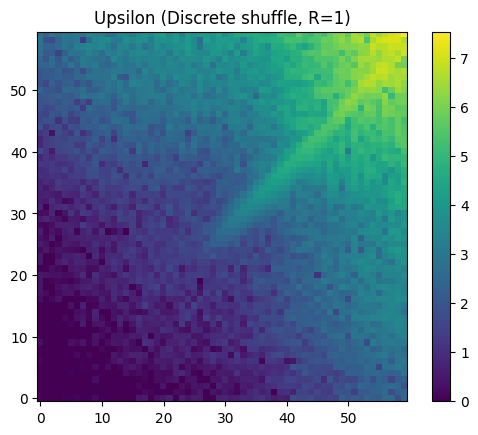

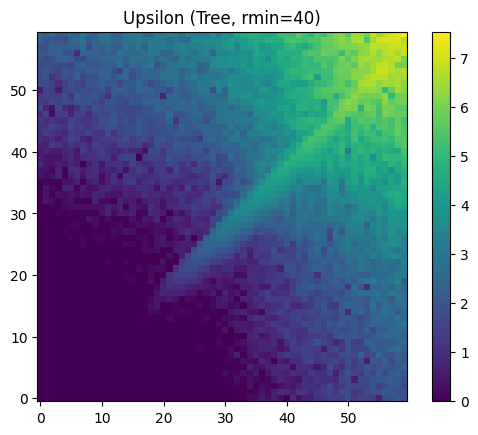

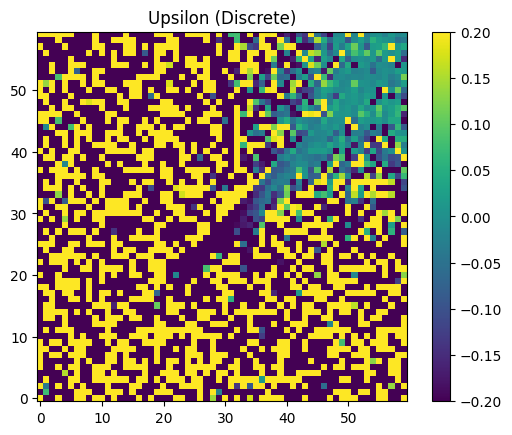

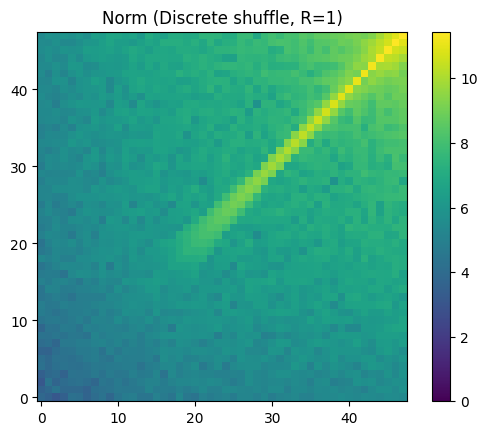

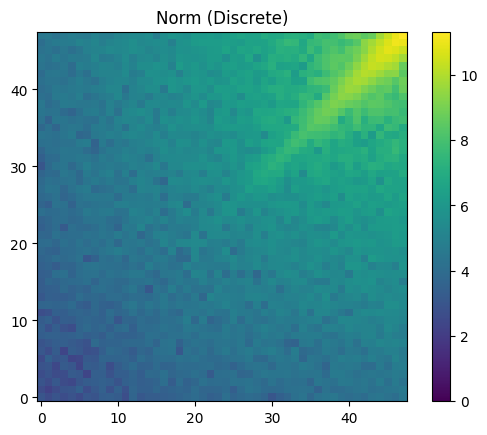

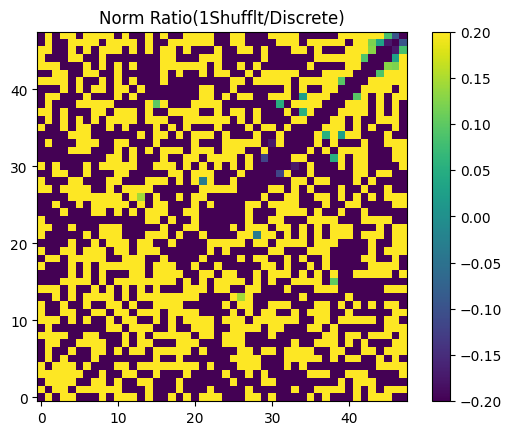

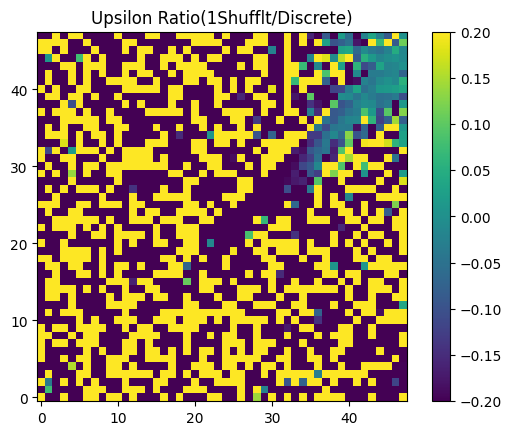

In [133]:
elcomp = 0
nmulti = 11
plt.imshow(np.log10(np.abs(data1shuff["Upsilon"])[elcomp,nmulti,0].real),vmin=0,origin="lower",interpolation=None)
plt.title("Upsilon (Discrete shuffle, R=1)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(treedata40["Upsilon"])[elcomp,nmulti,0].real),vmin=0,origin="lower",interpolation=None)
plt.title("Upsilon (Tree, rmin=40)")
plt.colorbar()
plt.show()

plt.imshow((data1shuff["Upsilon"].real/treedata40["Upsilon"].real)[elcomp,nmulti,0]-1.,vmin=-.2,vmax=.2,interpolation=None,origin="lower")
plt.title("Upsilon (Discrete)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(data1shuff["Norm"])[nmulti,0,:48,:48].real),vmin=0,origin="lower",interpolation=None)
plt.title("Norm (Discrete shuffle, R=1)")
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(discdata["Norm"])[nmulti,0].real),vmin=0,origin="lower",interpolation=None)
plt.title("Norm (Discrete)")
plt.colorbar()
plt.show()

plt.imshow((data1shuff["Norm"][:,:,:48,:48].real/discdata["Norm"].real)[nmulti,0]-1.,vmin=-.2,vmax=.2,interpolation=None,origin="lower")
plt.title("Norm Ratio(1Shufflt/Discrete)")
plt.colorbar()
plt.show()

plt.imshow((data1shuff["Upsilon"][:,:,:,:48,:48].real/discdata["Upsilon"].real)[elcomp,nmulti,0]-1.,vmin=-.2,vmax=.2,interpolation=None,origin="lower")
plt.title("Upsilon Ratio(1Shufflt/Discrete)")
plt.colorbar()
plt.show()

In [143]:
path_to_slics = "/cosma7/data/dp004/dc-port3/Data/SLICS/KiDS450/GalCatalog_LOS1.fits"
base_save = "/cosma/home/dp004/dc-port3/Projects/ToGithub/Orpheus/data/"
min_sep = 0.25
max_sep = 256.
rbins_per_double = 6
nbinsr = int(10*rbins_per_double)
nmax = 100
nthreads = 16

In [3]:
# Initialize full catalog
data = Table.read(path_to_slics)
pos1 = data["x_arcmin"].data
pos2 = data["y_arcmin"].data
gamma1 = data["shear1"].data
gamma2 = data["shear2"].data
e1 = data["eps_obs1"].data
e2 = data["eps_obs2"].data
zspec = data["z_spectroscopic"].data
zphot = data["z_photometric"].data
slicsfullreso = orpheus.SpinTracerCatalog(spin=2, pos1=pos1, pos2=pos2, tracer_1=gamma1, tracer_2=gamma2, zbins=None)
slicsfullreso_scalar = orpheus.ScalarTracerCatalog(pos1=pos1, pos2=pos2, tracer=gamma1, zbins=None)



# 1) Do fully discrete computation with reduced catalogs
reduced_resos = [8.0,4.0,2.0,1.0,0.5,0.25]
max_seps = [max_sep,max_sep,max_sep,max_sep,max_sep/4.]
nbinsrs = [nbinsr,nbinsr,nbinsr,nbinsr,nbinsr-2*rbins_per_double]
str_resos = ["8p0", "4p0", "2p0", "1p0", "0p5", "0p25"]
red_shuffle=True
slics_reduced = {}
for elreso, reduced_reso in enumerate(reduced_resos):
    fname_save = "ResoTest_SLICSNoiseless_discrete_reduced_shuffled%s"%str_resos[elreso]
    t1 = time()
    slics_reduced[reduced_reso] = slicsfullreso.reduce(reduced_reso, shuffle=True, ret_inst=True)

In [64]:
slics_reduced[2.0].ngal

90000

In [80]:
slicsfullreso.ngal/slics_reduced[2.0].ngal

34.12001111111111

In [98]:
thisreso = 1.0
print(np.sum(slicsfullreso.tracer_2),
      np.sum(slics_reduced[thisreso].tracer_2),
      np.sum(slics_reduced[thisreso].tracer_2)*slicsfullreso.ngal/slics_reduced[thisreso].ngal)
print(np.sum(slicsfullreso.weight), np.sum(slics_reduced[thisreso].weight))

559.3138793187867 64.00777989045577 546.1048629852897
3070801.0 3070801.0


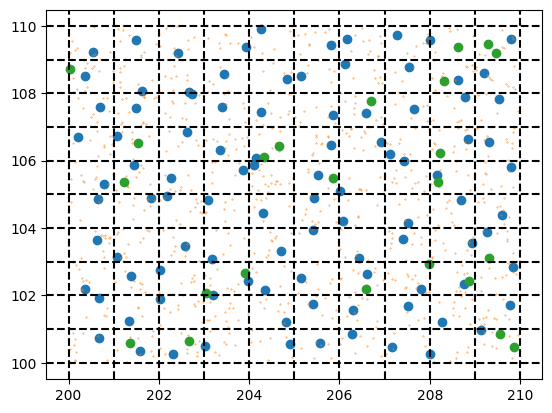

In [200]:
_x1s = 200
_x2s = 100
_d = 10
sel_1 = (slics_reduced[thisreso].pos1>_x1s) * (slics_reduced[thisreso].pos1<_x1s+_d) *(slics_reduced[thisreso].pos2>_x2s) * (slics_reduced[thisreso].pos2<_x2s+_d)
sel_t = (slicsfullresothinned.pos1>_x1s) * (slicsfullresothinned.pos1<_x1s+_d) *(slicsfullresothinned.pos2>_x2s) * (slicsfullresothinned.pos2<_x2s+_d)
sel_f = (slicsfullreso.pos1>_x1s) * (slicsfullreso.pos1<_x1s+_d) *(slicsfullreso.pos2>_x2s) * (slicsfullreso.pos2<_x2s+_d)
plt.scatter(slics_reduced[thisreso].pos1[sel_1],slics_reduced[thisreso].pos2[sel_1])
plt.scatter(slicsfullreso.pos1[sel_f],slicsfullreso.pos2[sel_f],s=.1)
plt.scatter(slicsfullresothinned.pos1[sel_t],slicsfullresothinned.pos2[sel_t])

for i in range(_d+1):
    plt.axhline(_x2s+i,color="k",ls="--")
    plt.axvline(_x1s+i,color="k",ls="--")

In [159]:
%%time
threepcf_reduced = orpheus.GGGCorrelation(n_cfs=4, min_sep=min_sep, max_sep=max_sep, nbinsr=nbinsr, nmaxs=10, 
                                          shuffle_pix=False, multicountcorr=False, method="Discrete")
threepcf_reduced.process(slics_reduced[2.0], nthreads=nthreads)

[2 2 2]
0.001473749057561812 0.0030513554821507867 599.9930161181809 599.9966286281104
-24.998526250942437 -24.99694864451785 624.9930161181809 624.9966286281104
25 25 25.99966169476493 25.99974309090513
0 [1 1 1 ... 1 1 1]
int32 <class 'numpy.ctypeslib.ndpointer_<i4_C_CONTIGUOUS'>
1 [31. 45. 31. ... 40. 30. 29.]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
2 [6.69502337e-02 1.38128175e+00 4.12540615e-01 ... 5.99984311e+02
 5.98204265e+02 5.98092988e+02]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
3 [  0.65997703   2.84502198   4.50030552 ... 594.2202242  597.34729168
 598.40917167]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
4 [-0.00678948 -0.00799814 -0.01318982 ...  0.00465612 -0.00295668
  0.0032764 ]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
5 [ 0.0116347   0.01491831  0.00308049 ...  0.00285059 -0.01024731
 -0.01549553]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
6 [0 0 0 ... 0 0 0]
int32 <class

In [167]:
slicsfullresothinned.ngal

102361

In [159]:
weights_thinned = np.abs(np.random.normal(loc=35,scale=8,size=len(pos1[::35])))
slicsfullresothinned = orpheus.SpinTracerCatalog(spin=2, pos1=pos1[::35], pos2=pos2[::35], weight=weights_thinned, 
                                                 tracer_1=gamma1[::35], tracer_2=gamma2[::35], zbins=None)

In [160]:
%%time
threepcf_thinned = orpheus.GGGCorrelation(n_cfs=4, min_sep=min_sep, max_sep=max_sep, nbinsr=nbinsr, nmaxs=10, 
                                          shuffle_pix=True, multicountcorr=True, method="Discrete")
threepcf_thinned.process(slicsfullresothinned, nthreads=nthreads)

[2 2 2]
0.005367212 0.00094911078 599.98993 599.99561
-24.994632788 -24.99905088922 624.98993 624.99561
25 25 25.999382511519997 25.999786435568804
0 [1 1 1 ... 1 1 1]
int32 <class 'numpy.ctypeslib.ndpointer_<i4_C_CONTIGUOUS'>
1 [32.04218077 43.99405258 30.6672303  ... 30.19340926 26.87093732
 41.72079225]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
2 [151.62956  273.50616  559.29535  ... 451.28528   28.872818 141.95174 ]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
3 [ 23.877169 186.38168  355.15775  ... 457.4877   335.25244  167.08507 ]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
4 [ 2.3887389e-06  6.6264409e-05  2.9386440e-06 ...  1.1785343e-01
 -6.1975077e-02 -6.6369817e-02]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
5 [ 1.7337958e-06  7.7604636e-05 -1.8159208e-06 ...  4.1320764e-02
  2.1835960e-02  7.7342227e-02]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
6 [0 0 0 ... 0 0 0]
int32 <class 'numpy.c

In [186]:
slics_reduced[2.0].pixs_galind_bounds[:100]

array([    0,     1,     7,    14,    21,    29,    37,    45,    51,
          54,    58,    63,    68,    74,    80,    87,    96,   101,
         107,   112,   120,   127,   134,   139,   144,   145,   152,
         320,   490,   656,   826,   991,  1158,  1328,  1503,  1676,
        1849,  2022,  2188,  2363,  2529,  2699,  2867,  3042,  3211,
        3375,  3550,  3716,  3883,  4053,  4060,  4066,  4236,  4405,
        4571,  4745,  4916,  5087,  5255,  5424,  5591,  5755,  5923,
        6090,  6257,  6427,  6592,  6764,  6928,  7101,  7269,  7438,
        7612,  7784,  7950,  7958,  7964,  8132,  8306,  8471,  8638,
        8811,  8978,  9140,  9312,  9479,  9644,  9816,  9984, 10154,
       10325, 10497, 10661, 10828, 10999, 11168, 11336, 11503, 11672,
       11837], dtype=int32)

In [144]:
slics_reduced[2.0].pix1_d

In [194]:
slicsfullresothinned.pixs_galind_bounds[:100]

array([    0,     8,    17,    25,    36,    45,    51,    53,    61,
          70,    75,    84,    92,    97,   105,   114,   124,   132,
         139,   146,   151,   155,   161,   165,   170,   328,   472,
         636,   799,   956,  1139,  1292,  1461,  1620,  1794,  1967,
        2130,  2278,  2461,  2644,  2850,  3013,  3189,  3354,  3513,
        3687,  3845,  4001,  4010,  4018,  4180,  4346,  4528,  4669,
        4824,  4997,  5177,  5351,  5527,  5686,  5847,  6022,  6183,
        6344,  6532,  6701,  6866,  7023,  7164,  7303,  7475,  7648,
        7818,  7825,  7831,  7983,  8130,  8291,  8465,  8643,  8787,
        8945,  9080,  9250,  9416,  9591,  9755,  9907, 10067, 10224,
       10387, 10552, 10707, 10881, 11040, 11221, 11389, 11557, 11567,
       11572], dtype=int32)

In [165]:
def multipoles2npcf(npcf_multi, npcfnorm_multi, phis):
    nbinsz = 1
    nmax, nzcombis, rbins, rbins = np.shape(npcf_multi[0])
    nmax -= 1
    npcf = np.zeros((4, nzcombis, rbins, rbins, len(phis)), dtype=np.complex128)
    npcf_norm = np.zeros((nzcombis, rbins, rbins, len(phis)), dtype=np.complex128)
    ztiler = np.arange(nbinsz*nbinsz*nbinsz).reshape(
        (nbinsz,nbinsz,nbinsz)).transpose(0,2,1).flatten().astype(int)

    # 3PCF components
    conjmap = [0,1,3,2]
    for elm in range(4):
        for elphi, phi in enumerate(phis):
            tmp = np.zeros((nzcombis, rbins, rbins), dtype=np.complex128)
            N0 = 1./(2*np.pi) * npcfnorm_multi[0].astype(np.complex128)
            for eln,n in enumerate(range(nmax+1)):
                _const = 1./(2*np.pi) * np.exp(1J*n*phi)
                tmp += _const * npcf_multi[elm,eln].astype(np.complex128)
                if n>0:
                    tmp += _const.conj() * npcf_multi[conjmap[elm],eln][ztiler].astype(np.complex128).transpose(0,2,1)
            npcf[elm,...,elphi] = tmp/N0.real
    # Number of triangles
    for elphi, phi in enumerate(phis):
        tmptotnorm = np.zeros((nzcombis, rbins, rbins), dtype=np.complex128)
        for eln,n in enumerate(range(nmax+1)):
            _const = 1./(2*np.pi) * np.exp(1J*n*phi)
            tmptotnorm += _const * npcfnorm_multi[eln].astype(np.complex128)
            if n>0:
                tmptotnorm += _const.conj() * npcfnorm_multi[eln][ztiler].astype(complex).transpose(0,2,1)
        npcf_norm[...,elphi] = tmptotnorm
    return npcf,npcf_norm 

In [326]:
nphis=100
npcfdisc, npcfdisc_norm = multipoles2npcf(discdata["Upsilon"], discdata["Norm"], np.linspace(-np.pi,np.pi,nphis))
npcfdisc1p0, npcfdisc1p0_norm = multipoles2npcf(data1["Upsilon"], data1["Norm"], np.linspace(-np.pi,np.pi,nphis))
npcfdisc1p0s, npcfdisc1p0s_norm = multipoles2npcf(data1shuff["Upsilon"], data1shuff["Norm"], np.linspace(-np.pi,np.pi,nphis))
npcfdisc2p0, npcfdisc2p0_norm = multipoles2npcf(data2["Upsilon"], data2["Norm"], np.linspace(-np.pi,np.pi,nphis))
npcfdisc2p0s, npcfdisc2p0s_norm = multipoles2npcf(data2shuff["Upsilon"], data2shuff["Norm"], np.linspace(-np.pi,np.pi,nphis))
npcftree5, npcftree5_norm = multipoles2npcf(treedata5["Upsilon"], treedata5["Norm"], np.linspace(-np.pi,np.pi,nphis))
npcftree10, npcftree10_norm = multipoles2npcf(treedata10["Upsilon"], treedata10["Norm"], np.linspace(-np.pi,np.pi,nphis))
npcftree20, npcftree20_norm = multipoles2npcf(treedata20["Upsilon"], treedata20["Norm"], np.linspace(-np.pi,np.pi,nphis))
npcftree40, npcftree40_norm = multipoles2npcf(treedata40["Upsilon"], treedata40["Norm"], np.linspace(-np.pi,np.pi,nphis))
npcfthinned35, npcfthinned35_norm = multipoles2npcf(threepcf_thinned.npcf_multipoles, threepcf_thinned.npcf_multipoles_norm, np.linspace(-np.pi,np.pi,nphis))

/tmp/ipykernel_75866/1498203499.py:21: RuntimeWarning: divide by zero encountered in true_divide
  npcf[elm,...,elphi] = tmp/N0.real
/tmp/ipykernel_75866/1498203499.py:21: RuntimeWarning: invalid value encountered in true_divide
  npcf[elm,...,elphi] = tmp/N0.real


/tmp/ipykernel_75866/2925982106.py:9: RuntimeWarning: invalid value encountered in multiply
  plt.semilogx(data2["Pars"]["bin_centers"][0][k:], data2["Pars"]["bin_centers"][0][k:]*np.diag(npcfdisc2p0s[elcomp,0,:,:,elphi],k=k).real, "r-")


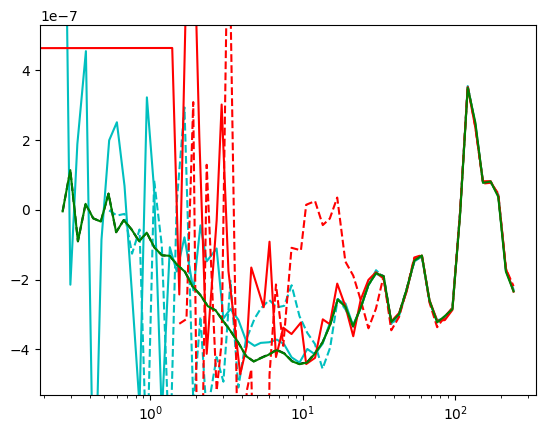

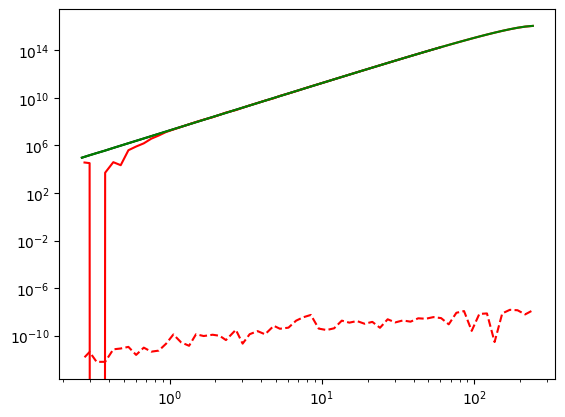

(0.9, 1.02)

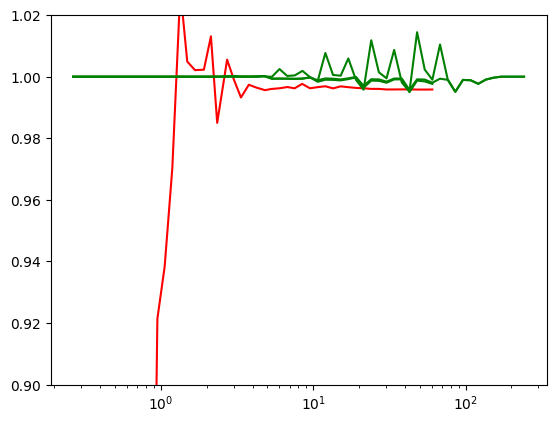

In [226]:
k=0
elcomp = 0
elphi = 1

plt.semilogx(discdata["Pars"]["bin_centers"][0][k:], discdata["Pars"]["bin_centers"][0][k:]*np.diag(npcfdisc[elcomp,0,:,:,elphi],k=k).real, "k--")
plt.semilogx(data1["Pars"]["bin_centers"][0][k:], data1["Pars"]["bin_centers"][0][k:]*np.diag(npcfdisc1p0[elcomp,0,:,:,elphi],k=k).real, "c--")
plt.semilogx(data1["Pars"]["bin_centers"][0][k:], data1["Pars"]["bin_centers"][0][k:]*np.diag(npcfdisc1p0s[elcomp,0,:,:,elphi],k=k).real, "c-")
plt.semilogx(data2["Pars"]["bin_centers"][0][k:], data2["Pars"]["bin_centers"][0][k:]*np.diag(npcfdisc2p0[elcomp,0,:,:,elphi],k=k).real, "r--")
plt.semilogx(data2["Pars"]["bin_centers"][0][k:], data2["Pars"]["bin_centers"][0][k:]*np.diag(npcfdisc2p0s[elcomp,0,:,:,elphi],k=k).real, "r-")
plt.semilogx(treedata20["Pars"]["bin_centers"][0][k:], treedata20["Pars"]["bin_centers"][0][k:]*np.diag(npcftree20[elcomp,0,:,:,elphi],k=k).real, "g-")
plt.ylim(-1.2*np.max(np.abs(discdata["Pars"]["bin_centers"][0][k:]*np.diag(npcfdisc[elcomp,0,:,:,elphi],k=k).real)),
        1.2*np.max(np.abs(discdata["Pars"]["bin_centers"][0][k:]*np.diag(npcfdisc[elcomp,0,:,:,elphi],k=k).real)))
plt.show()

plt.loglog(discdata["Pars"]["bin_centers"][0][k:], np.diag(npcfdisc_norm[0,:,:,elphi],k=k).real, "k-")
plt.loglog(discdata["Pars"]["bin_centers"][0][k:], np.abs(np.diag(npcfdisc_norm[0,:,:,elphi],k=k).imag), "k--")
plt.loglog(data1["Pars"]["bin_centers"][0][k:], np.diag(npcfdisc1p0s_norm[0,:,:,elphi],k=k).real, "r-")
plt.loglog(data1["Pars"]["bin_centers"][0][k:], np.abs(np.diag(npcfdisc1p0s_norm[0,:,:,elphi],k=k).imag), "r--")
plt.loglog(treedata20["Pars"]["bin_centers"][0][k:], np.diag(npcftree20_norm[0,:,:,elphi],k=k).real, "g-")
plt.loglog(treedata20["Pars"]["bin_centers"][0][k:], np.abs(np.diag(npcftree20_norm[0,:,:,elphi],k=k).imag), "g--")
plt.show()

plt.semilogx(data1["Pars"]["bin_centers"][0][k:48], np.diag(npcfdisc1p0s_norm[0,:48,:48,elphi],k=k).real/np.diag(npcfdisc_norm[0,:,:,elphi],k=k).real, "r-")
plt.semilogx(treedata20["Pars"]["bin_centers"][0][k:48], np.diag(npcftree20_norm[0,:48,:48,elphi],k=k).real/np.diag(npcfdisc_norm[0,:,:,elphi],k=k).real, "g-")
plt.semilogx(treedata20["Pars"]["bin_centers"][0][k:], np.diag(npcftree20_norm[0,:,:,elphi],k=k).real/np.diag(npcftree40_norm[0,:,:,elphi],k=k).real, "g-")
plt.semilogx(treedata10["Pars"]["bin_centers"][0][k:], np.diag(npcftree10_norm[0,:,:,elphi],k=k).real/np.diag(npcftree40_norm[0,:,:,elphi],k=k).real, "g-")
plt.ylim(.9,1.02)

In [357]:
(data2["Pars"]["bin_edges"][60]**2-data2["Pars"]["bin_edges"][59]**2)/(data2["Pars"]["bin_edges"][54]**2-data2["Pars"]["bin_edges"][53]**2)

4.0

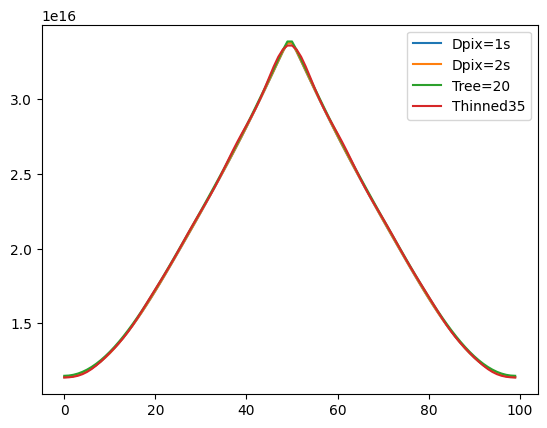

In [371]:
#plt.plot((npcfdisc_norm[0,33,33]-npcfdisc2p0s_norm[0,33,33])/np.max(npcfdisc_norm[0,33,33]))
elb1 = 59
elb2 = 59
#plt.plot(npcfdisc_norm[0,elb1,elb2], label="Discrete")
plt.plot(npcfdisc1p0s_norm[0,elb1,elb2], label="Dpix=1s")
plt.plot(npcfdisc2p0s_norm[0,elb1,elb2], label="Dpix=2s")
plt.plot(npcftree20_norm[0,elb1,elb2], label="Tree=20")
plt.plot(npcfthinned35_norm[0,elb1,elb2], label="Thinned35")
plt.legend()
#print(discdata["Pars"]["bin_centers"][0,elb1],discdata["Pars"]["bin_centers"][0,elb2])
#_ = np.max(npcfdisc_norm[0,elb1,elb2]) - np.min(npcfdisc_norm[0,elb1,elb2])
#plt.ylim(np.min(npcfdisc_norm[0,elb1,elb2])-.2*_,np.max(npcfdisc_norm[0,elb1,elb2])+.2*_)
#plt.plot(npcfdisc_norm[0,-1,-1]/np.max(npcfdisc_norm[0,-1,-1]))
#plt.plot(npcfdisc_norm[0,-22,-1]/np.max(npcfdisc_norm[0,-22,-1]))

In [379]:
for i in range(10):
    print(npcftree20_norm[0,6*i+5,6*i+5][66]/npcftree20_norm[0,6*i,6*i][66])

(9.95455215356587+0j)
(9.948648035049905+0j)
(10.052121191357712+0j)
(10.025568115065717+0j)
(9.983942595071394+0j)
(9.868218757242538+0j)
(9.65346902480325+0j)
(9.204285788702832+0j)
(8.26345881778374+0j)
(6.18380225797954+0j)


In [44]:
%%time
xipmmixednc = orpheus.XipmMixedCovariance(min_sep_xi=0.5, max_sep_xi=300., nbins_xi=9, nsubbins=5, nmax=10, 
                                        shuffle_pix=True, multicountcorr=False, method="Tree", tree_resos=[0,0.25,0.5,1.,2.,4.,8.])
xipmmixednc.process(slicsfullreso, nthreads=nthreads)

[0 0 0]
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-15.999989662318999 -15.999951384962 615.99976 615.9998799999998
78 78 8.102560893106654 8.102561940832844
0.25 3070801
0.0001932641030703285 0.001126966322879112 599.9996830538151 599.9998491430883
-15.999989662318999 -15.999951384962 615.99976 615.9998799999998
78 78 8.102560893106654 8.102561940832844
0.5 3070801
0.0003761905251405404 9.861635007021538e-05 599.99922342808 599.9996496711386
-15.999989662318999 -15.999951384962 615.99976 615.9998799999998
78 78 8.102560893106654 8.102561940832844
1.0 3070801
0.0007420433692809643 0.00016112672130751495 599.9977092682378 599.9981785756523
-15.999989662318999 -15.999951384962 615.99976 615.9998799999998
78 78 8.102560893106654 8.102561940832844
2.0 3070801
0.001473749057561812 0.0030513554821507867 599.9930161181809 599.9966286281104
-15.999989662318999 -15.999951384962 615.99976 615.9998799999998
78 78 8.102560893106654 8.102561940832844
4.0 3070801
0.1338901296885618 0.0060540959

/tmp/ipykernel_75866/3534012661.py:2: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(xipmmixed.npcf_multipoles[0,eln,0].real))


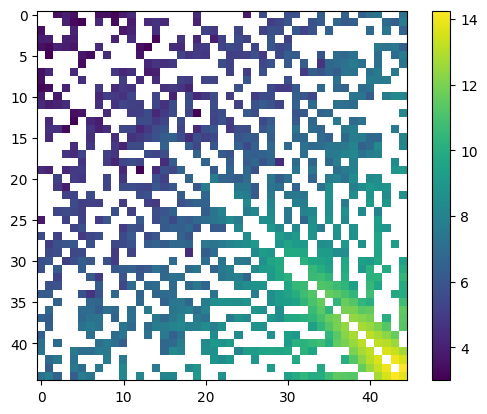

/tmp/ipykernel_75866/3534012661.py:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(xipmmixednc.npcf_multipoles[0,eln,0].real))


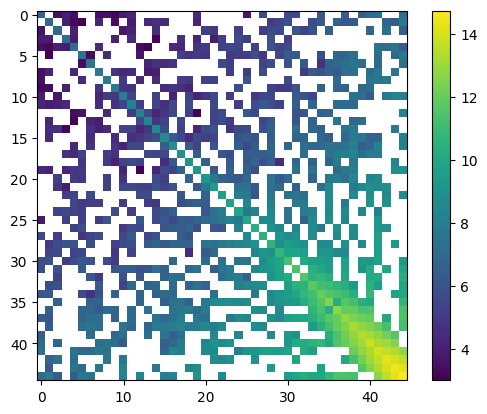

In [45]:
eln = 10
plt.imshow(np.log10(xipmmixed.npcf_multipoles[0,eln,0].real))
plt.colorbar()
plt.show()

plt.imshow(np.log10(xipmmixednc.npcf_multipoles[0,eln,0].real))
plt.colorbar()
plt.show()

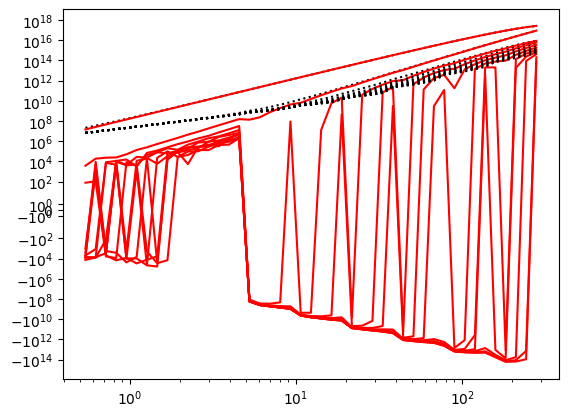

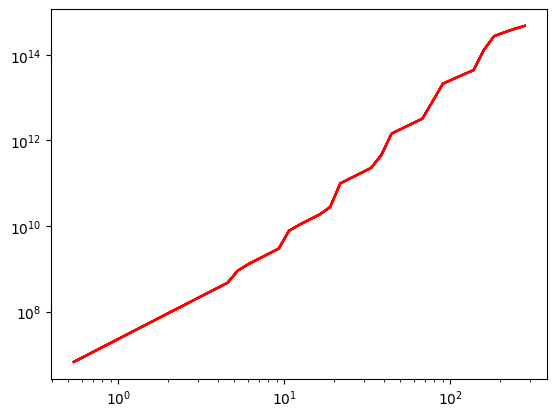

In [76]:
for eln in range(11):
    plt.loglog(xipmmixednc.bin_centers[0], np.diag(xipmmixednc.npcf_multipoles[0,eln,0].real),"k:")
    plt.loglog(xipmmixed.bin_centers[0], np.diag(xipmmixed.npcf_multipoles[0,eln,0].real),"r-")    
plt.yscale("symlog")
plt.show()
for eln in range(11):
    plt.loglog(xipmmixednc.bin_centers[0], np.diag(xipmmixednc.npcf_multipoles[0,eln,0].real)- np.diag(xipmmixed.npcf_multipoles[0,eln,0].real),"r-")

In [36]:
xipmmixed.bin_centers[0]

array([  0.55165311,   0.66227821,   0.79510493,   0.95455225,
         1.14596425,   1.37577159,   1.65164422,   1.98286528,
         2.38049415,   2.85786006,   3.43097247,   4.11899107,
         4.94498618,   5.93660208,   7.12706068,   8.5562457 ,
        10.27199262,  12.33175754,  14.804517  ,  17.77308273,
        21.33673924,  25.61493257,  30.75064301,  36.91587495,
        44.31676673,  53.20084392,  63.86509283,  76.66534327,
        92.02933095, 110.46847536, 132.59694017, 159.14983461,
       191.00468971, 229.20761893, 274.99742573])

In [12]:
cat.isinner.astype(np.int32)

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [25]:
xipmmixed.clib.alloc_triplets_tree_xipxipcov.args

AttributeError: '_FuncPtr' object has no attribute 'args'

In [61]:
xipmmixed.tree_resosatr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6],
      dtype=int32)

In [37]:
xipmmixed.order

3

In [66]:
slicsfullreso.ngal/slics_reduced[0.25].ngal

1.2901197145671979

In [67]:
xipmmixednc.tree_resosatr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6,
       6], dtype=int32)

In [70]:
ratio = np.ones_like(xipmmixednc.tree_resosatr).astype(float)
ratio[xipmmixednc.tree_resosatr==1] = slics_reduced[0.25].ngal/slicsfullreso.ngal
ratio[xipmmixednc.tree_resosatr==2] = slics_reduced[0.5].ngal/slicsfullreso.ngal
ratio[xipmmixednc.tree_resosatr==3] = slics_reduced[1.0].ngal/slicsfullreso.ngal
ratio[xipmmixednc.tree_resosatr==4] = slics_reduced[2.0].ngal/slicsfullreso.ngal
ratio[xipmmixednc.tree_resosatr==5] = slics_reduced[4.0].ngal/slicsfullreso.ngal

In [118]:
print(np.sum(slics_reduced[2.0].weight*slics_reduced[2.0].tracer_1))
np.sum(slicsfullreso.weight*slicsfullreso.tracer_1)

-2379.2030587544928


-2379.2030587544937

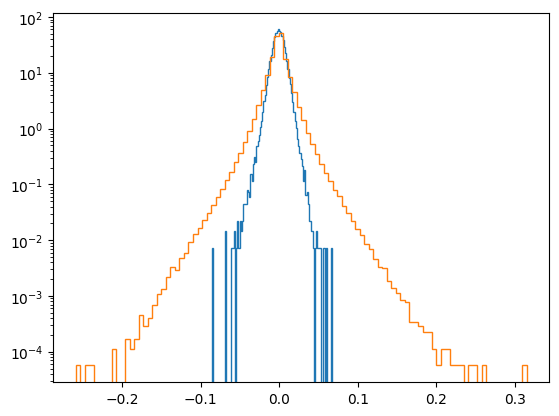

In [113]:
plt.hist(slics_reduced[2.0].tracer_1,bins=100,histtype="step",density=True)
plt.hist(slicsfullreso.tracer_1,bins=100,histtype="step",density=True)
plt.yscale("log")

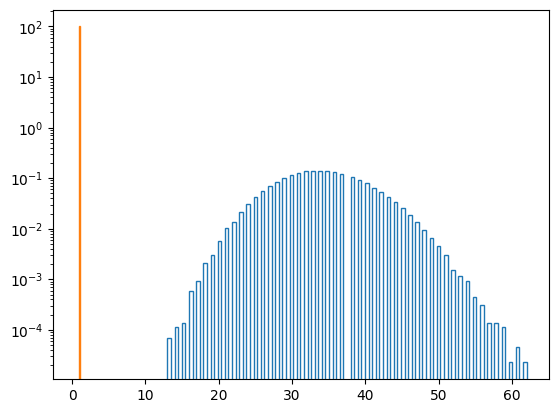

In [112]:
plt.hist(slics_reduced[2.0].weight,bins=100,histtype="step",density=True)
plt.hist(slicsfullreso.weight,bins=100,histtype="step",density=True)
plt.yscale("log")

In [153]:
class Node():
    def __init__(self, x0, y0, w, h, points):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.points = points
        self.children = []

    def get_width(self):
        return self.width
    
    def get_height(self):
        return self.height
    
    def get_points(self):
        return self.points
    
def recursive_subdivide(node, k):
    if len(node.points)<=k:
        return
   
    w_ = float(node.width/2)
    h_ = float(node.height/2)

    p = contains(node.x0, node.y0, w_, h_, node.points)
    x1 = Node(node.x0, node.y0, w_, h_, p)
    recursive_subdivide(x1, k)

    p = contains(node.x0, node.y0+h_, w_, h_, node.points)
    x2 = Node(node.x0, node.y0+h_, w_, h_, p)
    recursive_subdivide(x2, k)

    p = contains(node.x0+w_, node.y0, w_, h_, node.points)
    x3 = Node(node.x0 + w_, node.y0, w_, h_, p)
    recursive_subdivide(x3, k)

    p = contains(node.x0+w_, node.y0+h_, w_, h_, node.points)
    x4 = Node(node.x0+w_, node.y0+h_, w_, h_, p)
    recursive_subdivide(x4, k)

    node.children = [x1, x2, x3, x4]
   
   
def contains(x, y, w, h, points):
    pts = []
    for point in points:
        if point.x >= x and point.x <= x+w and point.y>=y and point.y<=y+h:
            pts.append(point)
    return pts


def find_children(node):
    if not node.children:
        return [node]
    else:
        children = []
        for child in node.children:
            children += (find_children(child))
    return children

import random
import matplotlib.pyplot as plt # plotting libraries
import matplotlib.patches as patches

class QTree():
    def __init__(self, k, n):
        self.threshold = k
        self.points = [Point(random.uniform(0, 10), random.uniform(0, 10)) for x in range(n)]
        self.root = Node(0, 0, 10, 10, self.points)

    def add_point(self, x, y):
        self.points.append(Point(x, y))
    
    def get_points(self):
        return self.points
    
    def subdivide(self):
        recursive_subdivide(self.root, self.threshold)
    
    def graph(self):
        fig = plt.figure(figsize=(12, 8))
        plt.title("Quadtree")
        c = find_children(self.root)
        print("Number of segments: %d" %len(c))
        areas = set()
        for el in c:
            areas.add(el.width*el.height)
        print("Minimum segment area: %.3f units" %min(areas))
        for n in c:
            plt.gcf().gca().add_patch(patches.Rectangle((n.x0, n.y0), n.width, n.height, fill=False))
        x = [point.x for point in self.points]
        y = [point.y for point in self.points]
        plt.plot(x, y, 'ro') # plots the points as red dots
        plt.show()
        return
    
class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y

Number of segments: 1
Minimum segment area: 100.000 units


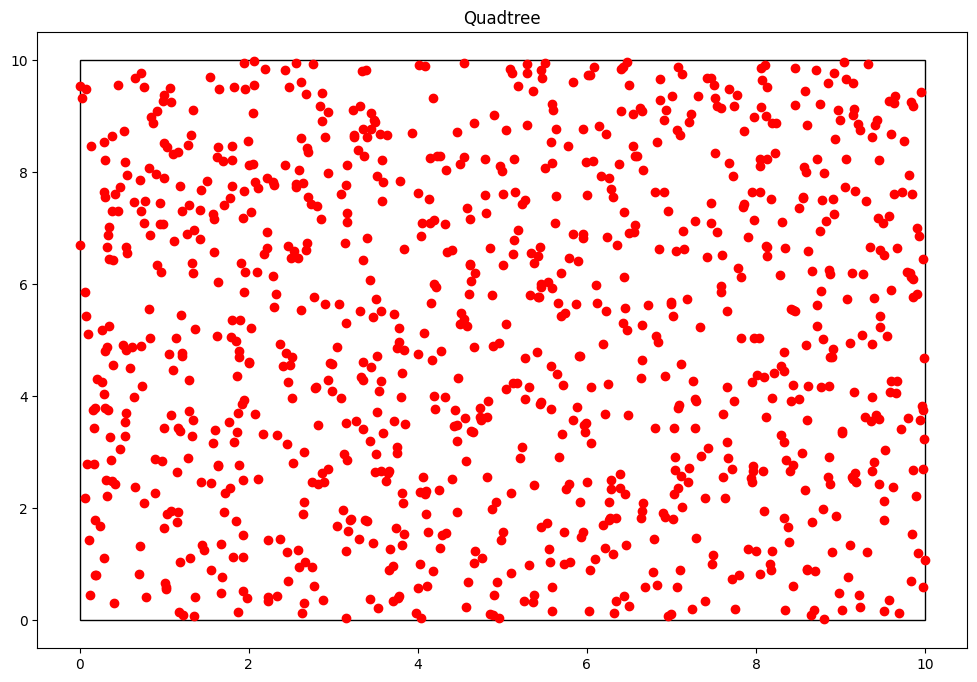

In [158]:
tree = QTree(10,1000)
tree.graph()

(array([1.04880e+04, 4.27460e+04, 1.33569e+05, 8.67400e+04, 6.72690e+04,
        1.39100e+04, 4.70500e+03, 4.03000e+02, 8.90000e+01, 3.00000e+00]),
 array([ 1. ,  3.5,  6. ,  8.5, 11. , 13.5, 16. , 18.5, 21. , 23.5, 26. ]),
 <BarContainer object of 10 artists>)

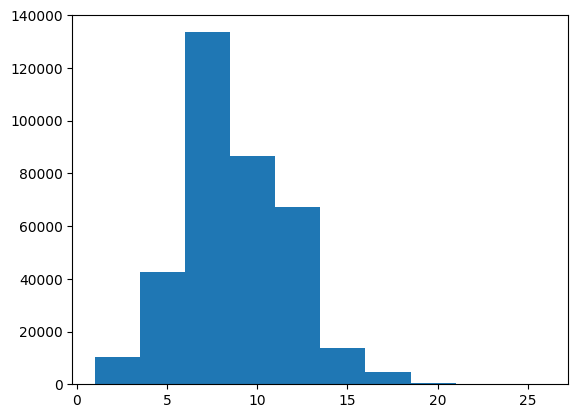

In [222]:
plt.hist(slics_reduced[1.0].weight)

In [713]:
qtree = {}
depth_max = 10
_max = 
for depth in range(depth_max+1):
    

slicsfullreso.pos1

SyntaxError: invalid syntax (1738045411.py, line 3)

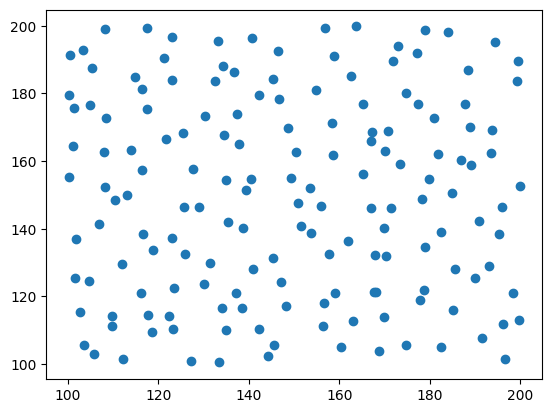

In [714]:
reso = 8.0
_min = 100
_max = 200
sel = (slics_reduced[reso].pos1>_min) * (slics_reduced[reso].pos1<=_max) * (slics_reduced[reso].pos2>_min) * (slics_reduced[reso].pos2<=_max)
plt.scatter(slics_reduced[8.0].pos1[sel], slics_reduced[8.0].pos2[sel])

In [5]:
def multihash(inst, dpixs, fields, dpix_hash=None, tomo=False, normed=False, shuffle=False,
                  extent=[None,None,None,None], forcedivide=1):
        """ Builds spatialhash for a base catalog and its reductions. """
        
        dpixs = sorted(dpixs)
        if dpix_hash is None:
            dpix_hash = dpixs[-1]
        if extent[0] is None:
            extent = [inst.min1-dpix_hash, inst.max1+dpix_hash, inst.min2-dpix_hash, inst.max2+dpix_hash]
            #extent = [self.min1, self.max1+dpix_hash-self.len1%dpix_hash, 
            #          self.min2, self.max2+dpix_hash-self.len2%dpix_hash]
        
        # Initialize spatial hash for discrete catalog
        inst.build_spatialhash(dpix=dpix_hash, extent=extent)
        fac_pix = inst.pix1_d/dpixs[-1]
        dpixs_true = np.zeros_like(np.asarray(dpixs))
        
        ngals = [inst.ngal]
        pos1s = [inst.pos1]
        pos2s = [inst.pos2]
        weights = [inst.weight]
        zbins = [inst.zbins*tomo]
        allfields = [fields]
        index_matchers = [inst.index_matcher]
        pixs_galind_bounds = [inst.pixs_galind_bounds]
        pix_gals = [inst.pix_gals]
        
        # Build spatial hashes for reduced catalogs 
        for elpix, dpix in enumerate(dpixs):
            print(dpix, len(inst.pos1))
            dpixs_true[elpix] = dpix*fac_pix
            nextcat, fields_red = inst._reduce(fields=fields,
                                               dpix=dpix*fac_pix, 
                                               tomo=tomo, 
                                               normed=normed, 
                                               shuffle=shuffle,
                                               extent=extent, 
                                               forcedivide=forcedivide, 
                                               ret_inst=True)
            nextcat.build_spatialhash(dpix=dpix_hash, extent=extent)
            ngals.append(nextcat.ngal)
            pos1s.append(nextcat.pos1)
            pos2s.append(nextcat.pos2)
            weights.append(nextcat.weight)
            zbins.append(nextcat.zbins)
            allfields.append(fields_red)
            index_matchers.append(nextcat.index_matcher)
            pixs_galind_bounds.append(nextcat.pixs_galind_bounds)
            pix_gals.append(nextcat.pix_gals)
            
        return ngals, pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals, dpixs_true

In [23]:
#dpixs=[0.2,0.4,0.8,1.6,3.2,6.4]
dpixs= [0.2120313872998889*i for i in [1,2,4,8,16,32,64]]
#dpixs=[0.25,0.5,1.0,2.,4.]
extent = [slicsfullreso.min1-1.*dpixs[-1], slicsfullreso.max1+1.*dpixs[-1],#+slicsfullreso.len1#%dpixs[-1], 
          slicsfullreso.min2-1.*dpixs[-1], slicsfullreso.max2+1.*dpixs[-1]]#+(1+1e-10)*dpixs[-1]-slicsfullreso.len2%dpixs[-1]]
#extent = [0.,640.,0.,640.]
#_ = slicsfullreso.multihash(dpixs=dpixs, extent=extent)
_ = multihash(slicsfullreso, fields=[slicsfullreso.tracer_1, slicsfullreso.tracer_2], dpixs=dpixs, extent=extent)
ngals, pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals, dpixs_true = _

1.0337681e-05 4.8615038e-05 599.99976 599.99988
-27.140007236704783 -27.13996895934778 627.1397775743859 627.1398975743858
48 48 13.630828850231056 13.630830552786117
0.2120313872998889 3070801
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-27.140007236704783 -27.13996895934778 627.1397775743859 627.1398975743858
48 48 13.630828850231056 13.630830552786117
0.4240627745997778 3070801
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-27.140007236704783 -27.13996895934778 627.1397775743859 627.1398975743858
48 48 13.630828850231056 13.630830552786117
0.8481255491995556 3070801
3.7718564e-05 4.8615038e-05 599.99976 599.99988
-27.140007236704783 -27.13996895934778 627.1397775743859 627.1398975743858
48 48 13.630828850231056 13.630830552786117
1.6962510983991113 3070801
3.7718564e-05 0.00024391338 599.99768 599.99988
-27.140007236704783 -27.13996895934778 627.1397775743859 627.1398975743858
48 48 13.630828850231056 13.630830552786117
3.3925021967982225 3070801
0.00030817464 0.0021351501 599

In [24]:
resos = np.append([0], dpixs_true)
print(resos)
ind_targets = [None]*(len(resos)-1)
ind_targetmatcher = [None]*(len(resos)-1)
for elreso in range(1,len(resos)):
    thisn1 = int(slicsfullreso.pix1_n*slicsfullreso.pix1_d/resos[elreso])
    thisn2 = int(slicsfullreso.pix2_n*slicsfullreso.pix2_d/resos[elreso])
    ipix_1 = np.floor((pos1s[elreso] - slicsfullreso.pix1_start)/resos[elreso]).astype(np.int32)
    ipix_2 = np.floor((pos2s[elreso] - slicsfullreso.pix2_start)/resos[elreso]).astype(np.int32)
    ind_targets[elreso-1] = (ipix_2*thisn1 + ipix_1).astype(np.int32)
    ind_targetmatcher[elreso-1] = np.zeros(thisn1*thisn2, dtype=np.int32)
    ind_targetmatcher[elreso-1][ind_targets[elreso-1]] = np.arange(ngals[elreso], dtype=np.int32)
    print(elreso, len(ind_targetmatcher[elreso-1]), np.max(ind_targets[elreso-1]), np.max(ind_targetmatcher[elreso-1]))

pixmatcher = [None]*(len(resos)-1)
for elreso in range(len(resos)-1):
    pixmatcher[elreso] = [None]*(len(resos)-elreso-1)
print(pixmatcher)
pixmatcher = [None]*(len(resos)-1)
for elreso in range(len(resos)-1):
    pixmatcher[elreso] = [None]*(len(resos)-elreso-1)
    for elreso2 in range(elreso+1, len(resos)):
        ipix_1 = np.floor((pos1s[elreso] - slicsfullreso.pix1_start)/resos[elreso2]).astype(np.int32)
        ipix_2 = np.floor((pos2s[elreso] - slicsfullreso.pix2_start)/resos[elreso2]).astype(np.int32)
        indreso = (ipix_2*(slicsfullreso.pix1_n*slicsfullreso.pix1_d/resos[elreso2]) + ipix_1).astype(np.int32)
        toobig = np.argwhere(indreso>=len(ind_targetmatcher[elreso2-1]))
        #if len(toobig)>0:
        #    indreso -= indreso[0]
        #    indreso %= len(ind_targetmatcher[elreso2-1])
        #indreso[toobig] -= np.min(indreso)+1
        print(elreso,elreso2,len(indreso),len(np.unique(indreso)), len(toobig))
        pixmatcher[elreso][elreso2-(elreso+1)] = ind_targetmatcher[elreso2-1][indreso]
        print(len(pixmatcher[elreso][elreso2-(elreso+1)]))

[ 0.          0.2129817   0.4259634   0.8519268   1.70385361  3.40770721
  6.81541443 13.63082885]
1 9437184 9046909 2546118
2 2359296 2262462 1562090
3 589824 565983 496112
4 147456 141679 124971
5 36864 35511 31622
6 9216 8923 8092
7 2304 2253 2111
[[None, None, None, None, None, None, None], [None, None, None, None, None, None], [None, None, None, None, None], [None, None, None, None], [None, None, None], [None, None], [None]]
0 1 3070801 2546485 0
3070801
0 2 3070801 1562795 0
3070801
0 3 3070801 496265 0
3070801
0 4 3070801 125065 0
3070801
0 5 3070801 31660 0
3070801
0 6 3070801 8096 0
3070801
0 7 3070801 2112 0
3070801
1 2 2546119 1517173 0
2546119
1 3 2546119 495900 0
2546119
1 4 2546119 125035 0
2546119
1 5 2546119 31656 0
2546119
1 6 2546119 8096 0
2546119
1 7 2546119 2112 0
2546119
2 3 1562091 494998 0
1562091
2 4 1562091 124947 0
1562091
2 5 1562091 31631 0
1562091
2 6 1562091 8095 0
1562091
2 7 1562091 2112 0
1562091
3 4 496113 124870 0
496113
3 5 496113 31605 0
496113
3 6

In [21]:
print(slicsfullreso.min1, slicsfullreso.pix1_start, slicsfullreso.pix1_d, slicsfullreso.pix1_n)
print(slicsfullreso.min1, slicsfullreso.pix2_start, slicsfullreso.pix2_d, slicsfullreso.pix2_n)

1.0337681e-05 -20.25228864131433 10.166735676512852 63
1.0337681e-05 -20.252250363957327 10.16673697369766 63


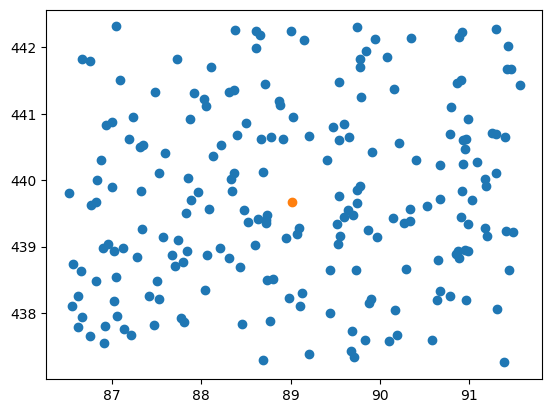

In [22]:
elreso = 0
elreso2 = 6
pix_target = 2231
tmpsel = np.argwhere(pixmatcher[elreso][elreso2-elreso-1] == pix_target).flatten()
plt.scatter(pos1s[elreso][tmpsel],pos2s[elreso][tmpsel])
plt.scatter(pos1s[elreso2][pix_target],pos2s[elreso2][pix_target])

In [592]:
pixmatcher

[[array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  array([      0,   83293,       0, ...,       0,       0, 1399152],
        dtype=int32),
  array([267006,  35211, 592448, ..., 152332, 501359, 588193], dtype=int32),
  array([ 68306,   9203, 153128, ...,  38920, 129250, 151878], dtype=int32),
  array([16864,  2233, 38197, ...,  9512, 32177, 37808], dtype=int32),
  array([4050,  524, 9627, ..., 2269, 8038, 9432], dtype=int32),
  None],
 None,
 None,
 None,
 None,
 None,
 None]

In [514]:
np.append([0], dpixs_true)

array([ 0.        ,  0.16026901,  0.32053802,  0.64107605,  1.2821521 ,
        2.56430419,  5.12860839, 10.25721678])

In [596]:
thisreso = 5
print(resos[thisreso])
print(pos1s[thisreso][:10])
print(pos2s[thisreso][:10])
#ipix_1

2.5315373723825836
[1.30194361 1.27266402 1.352054   1.16875225 1.46434366 1.0271807
 1.39980164 1.25959174 1.31741579 1.21708088]
[ 1.37068214  3.67177237  6.27181432  8.95324097 11.55724582 14.08154666
 16.23227429 18.94273826 21.52814516 24.04526288]


In [597]:
slicsfullreso.len1%dpixs[-1]

2.5569297819568533

In [555]:
np.sum(pixmatcher[0][5]>0)

2988448

In [781]:
(slicsfullreso.max2+dpixs[-1]-slicsfullreso.len2%dpixs[-1]-slicsfullreso.min2)/6.4

94.72676621819907

In [24]:
slicsfullreso.pix2_n

96

In [54]:
dpix = 6.4
thismin1 = extent[0]
thismin2 = extent[2]
thismax1 = extent[1]
thismax2 = extent[3]
pix1_start = thismin1 - dpix/1.
pix2_start = thismin2 - dpix/1.
stop1 = thismax1 + dpix/1.
stop2 = thismax2 + dpix/1.
pix1_n = int(np.round((stop1-pix1_start)/dpix))
pix2_n = int(np.round((stop2-pix2_start)/dpix))
npix = pix1_n * pix2_n
pix1_d = (stop1-pix1_start)/(pix1_n)
pix2_d = (stop2-pix2_start)/(pix2_n)

In [56]:
pix2_d

6.400000000000001

In [183]:
for i in range(6):
    print(np.max(pos2s[i]))

599.99988
599.99988
599.99988
599.99988
599.9931
599.9540075


In [28]:
slicsfullreso.pix2_d/resos

/tmp/ipykernel_174697/2540707377.py:1: RuntimeWarning: divide by zero encountered in true_divide
  slicsfullreso.pix2_d/resos


array([inf, 32., 16.,  8.,  4.,  2.,  1.])

In [35]:
fthin = 20
slicsthinnedzs = np.zeros_like(pos1[::fthin]).astype(int)
slicsthinnedzs[1::5] = 1
slicsthinnedzs[2::5] = 1
slicsthinnedzs[3::5] = 1
slicsthinnedzs[4::5] = 1
tomoslicsthinned1 = orpheus.SpinTracerCatalog(spin=2, pos1=pos1[::fthin], pos2=pos2[::fthin], 
                                                              tracer_1=gamma1[::fthin], tracer_2=gamma2[::fthin], 
                                                              zbins=slicsthinnedzs)
tomoslicsthinned1s = orpheus.ScalarTracerCatalog(pos1=pos1[::fthin], pos2=pos2[::fthin], tracer=gamma1[::fthin],
                                                              zbins=slicsthinnedzs)

In [36]:
%%time
xipmmixed = orpheus.XipmMixedCovariance(min_sep_xi=0.5, max_sep_xi=300., nbins_xi=9, nsubbins=5, nmax=10, 
                                        shuffle_pix=True, multicountcorr=True, method="Tree", tree_resos=[0,0.25,0.5,1.,2.,4.,8.])
xipmmixed.process(tomoslicsthinned1s, nthreads=16, dotomo=True)

[0 0 0]
0.00030817464 0.00094911078 599.99591 599.99768
-15.99969182536 -15.999050889220001 615.99591 615.99768
79 79 7.99994432690329 7.9999586188508855
0.25 153541
0.008675661640472374 0.0076995322652814524 599.9980148593886 599.997310954205
-15.99969182536 -15.999050889220001 615.99591 615.99768
79 79 7.99994432690329 7.9999586188508855
0.5 153541
0.01704314864094498 0.011012122216752221 599.9993201429021 599.99988677673
-15.99969182536 -15.999050889220001 615.99591 615.99768
79 79 7.99994432690329 7.9999586188508855
1.0 153541
0.03377812264189019 0.004247121924295978 599.9990101084109 599.9948080027821
-15.99969182536 -15.999050889220001 615.99591 615.99768
79 79 7.99994432690329 7.9999586188508855
2.0 153541
0.011841160250669707 0.008969348803260425 599.9991808459158 599.9865078944088
-15.99969182536 -15.999050889220001 615.99591 615.99768
79 79 7.99994432690329 7.9999586188508855
4.0 153541
0.13418796664756144 0.061780711608483224 599.990461999546 599.9940316359854
-15.9996918253

In [6]:
xipmmixed.tree_redges

array([  0.5,   5. ,  10. ,  20. ,  40. ,  80. , 160. , 300. ])

In [12]:
xipmmixed.npcf_multipoles.shape

(1, 11, 8, 45, 45)

/tmp/ipykernel_124743/1005781222.py:2: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(xipmmixed.npcf_multipoles[0,eln,0].real))


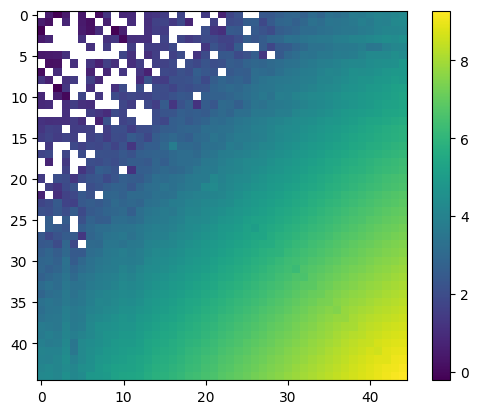

/tmp/ipykernel_124743/1005781222.py:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(xipmmixed.npcf_multipoles[0,eln,4].real))


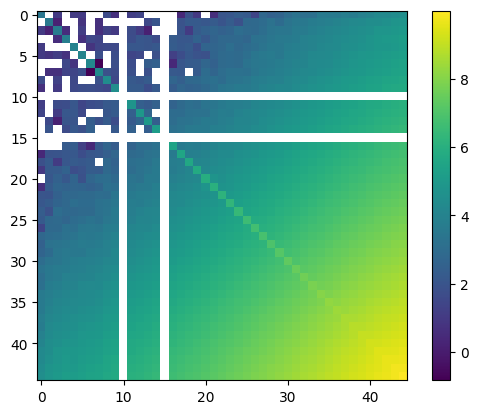

In [33]:
eln = 9
plt.imshow(np.log10(xipmmixed.npcf_multipoles[0,eln,0].real))
plt.colorbar()
plt.show()

plt.imshow(np.log10(xipmmixed.npcf_multipoles[0,eln,4].real))
plt.colorbar()
plt.show()

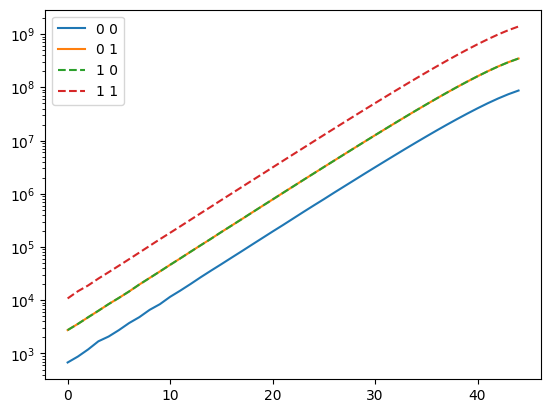

In [25]:
for i in range(2):
    for j in range(2):
        plt.semilogy(xipmmixed.wwcounts[i,j],ls=["-","--"][i],label="%i %i"%(i,j))
plt.legend()

3600

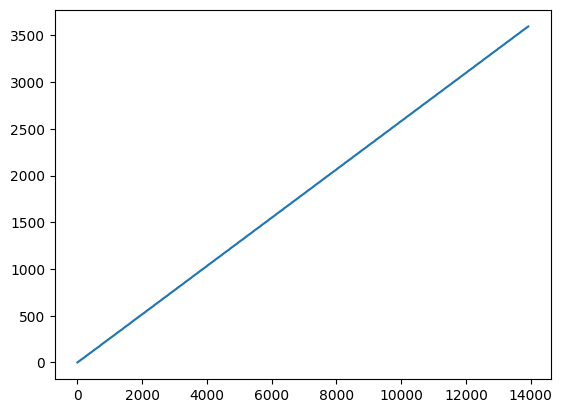

In [399]:
plt.plot(np.sort(indreso))
len(ind_targetmatcher[elreso2-1])

In [239]:
pixmatcher

[[array([ 766607, 2020576, 2467681, ...,  269934,   28964, 1211099],
        dtype=int32),
  array([ 737913, 1946495, 2377293, ...,  259987,   28000, 1166298],
        dtype=int32),
  array([ 638297, 1683360, 2056027, ...,  224892,   24413, 1008383],
        dtype=int32),
  array([ 384612, 1015588, 1240442, ...,  134986,   14988,  608973],
        dtype=int32),
  array([119900, 316490, 387100, ...,  42083,   4507, 189634], dtype=int32),
  array([30028, 79144, 96909, ..., 10374,  1225, 47355], dtype=int32),
  array([ 7445, 19791, 24374, ...,  2607,   268, 11809], dtype=int32)],
 [array([      0,       1,       3, ..., 2921090, 2921091, 2921092],
        dtype=int32),
  array([      0,       2,      10, ..., 2526567, 2526568, 2526569],
        dtype=int32),
  array([      0,       2,      13, ..., 1524160, 1524160, 1524162],
        dtype=int32),
  array([     0,      1,      7, ..., 475349, 475349, 475350], dtype=int32),
  array([     0,      0,      3, ..., 119022, 119022, 119022], dty

In [493]:
def gen_pixelmatcher(inst, dpixs, flattened=True):
    """
    Shapes of the unflattened arrays/lists:
    - ngals/resos1/resos2: (nresos,)
    - ngalshifts_1d: (nresos+1,)
    - ngalshifts_2d: (nresos-1, nresos)
    - pos1s/pos1s/weights/zbins: (ngals_reso1 + ngal_reso2 + ... + ngal_nresos)==(cumgals,)
    - allfields: (nfields, cumgals)
    - index_matchers: (nresos, npix_spatialhash)
    - pixs_galind_bounds/pix_gals:  (cumgals,)
    - pixmatcher: (nresos*ngal_reso1 + (nresos-1)*ngal_reso2 + ... + 1*ngal_{nresos-1}, )
    """
    _ = _gen_pixelmatcher(inst, dpixs, change_renormsign=False)
    failed, *res = _
    if failed:
        print("Pixelmapper creation failed first try....shuffling grid")
        _ = _gen_pixelmatcher(inst, dpixs, change_renormsign=True)
        failed, *res = _
    if not flattened:
        return res
    else:
        ngals = res[0]
        nresos = len(ngals)
        ngalshifts_1d = np.append(np.array([0]), np.cumsum(ngals)).astype(np.int32)
        pos1s = np.hstack(res[1]).squeeze()
        pos2s = np.hstack(res[2]).squeeze()
        weights = np.hstack(res[3]).squeeze()
        zbins = np.hstack(res[4]).squeeze()
        allfields = [None]*len(res[5][0])
        for elf in range(len(res[5][0])):
            allfields[elf] = np.zeros(ngalshifts_1d[-1], dtype=type(res[5][0][elf][0]))
            for elreso in range(nresos):
                #print(elf,elreso,len(res[elreso][elf]),ngalshifts_1d[elreso]-ngalshifts_1d[elreso+1])
                allfields[elf][ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]] = res[5][elreso][elf]
        index_matchers = np.hstack(res[6]).squeeze() # length: nresos*self.pix1_n*self.pix2_n
        pixs_galind_bounds = np.hstack(res[7]).squeeze()
        pix_gals = np.hstack(res[8]).squeeze()
        resos1 = res[9]
        resos2 = res[10]
        _tmpshift = 0
        ngalshifts_2d = -1*np.ones((nresos-1,nresos), dtype=np.int32)
        for elreso in range(nresos-1):
            ngalshifts_2d[elreso][elreso] = _tmpshift
            for elreso2 in range(elreso+1,nresos):
                _tmpshift += ngals[elreso]
                ngalshifts_2d[elreso][elreso2] = _tmpshift
        pixmatcher = np.zeros(ngalshifts_2d[-1][-1])
        for elreso in range(nresos-1):
            for elreso2 in range(elreso+1,nresos):
                _start = ngalshifts_2d[elreso][elreso2-1]
                _toappend = res[11][elreso][elreso2-elreso-1]
                pixmatcher[_start:_start+len(_toappend)] = _toappend
                #print(elreso,elreso2,len(res[11]),len(res[11][0]),_start,len(_toappend))
    return np.array(ngals, dtype=np.int32), resos1.astype(np.float64), resos2.astype(np.float64), \
           ngalshifts_1d, ngalshifts_2d.flatten(), \
           pos1s, pos2s, weights, zbins, allfields, \
           index_matchers, pixs_galind_bounds, pix_gals, pixmatcher

def _gen_pixelmatcher(inst, dpixs, change_renormsign=False):
    
    # Build multihashsh
    _min1 = inst.min1-2.*dpixs[-1]
    _max1 = inst.max1+2.*dpixs[-1]
    _min2 = inst.min2-2.*dpixs[-1]
    _max2 = inst.max2+2.*dpixs[-1]
    _renorm = (-1)**change_renormsign*dpixs[-1]*1e-5
    extent = [_min1, _max1-(_max1-_min1)%dpixs[-1]-_renorm, 
              _min2, _max2-(_max2-_min2)%dpixs[-1]-_renorm]
    _ = inst.multihash(dpixs=dpixs, extent=extent, shuffle=False)
    ngals, pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals, dpixs1_true, dpixs2_true = _ 
    
    # Match reduced pixelgrids between catalogs
    resos1 = np.append([0], dpixs1_true)
    resos2 = np.append([0], dpixs2_true)
    #print(resos1,resos2)
    ind_targets = [None]*(len(resos1)-1)
    ind_targetmatcher = [None]*(len(resos1)-1)
    for elreso in range(1,len(resos1)):
        thisn1 = int(inst.pix1_n*inst.pix1_d/resos1[elreso])
        thisn2 = int(inst.pix2_n*inst.pix2_d/resos2[elreso])
        ipix_1 = np.floor((pos1s[elreso] - inst.pix1_start)/resos1[elreso]).astype(np.int32)
        ipix_2 = np.floor((pos2s[elreso] - inst.pix2_start)/resos2[elreso]).astype(np.int32)
        ind_targets[elreso-1] = (ipix_2*thisn1 + ipix_1).astype(np.int32)
        ind_targetmatcher[elreso-1] = np.zeros(thisn1*thisn2, dtype=np.int32)
        ind_targetmatcher[elreso-1][ind_targets[elreso-1]] = np.arange(ngals[elreso], dtype=np.int32)
        #print(elreso, len(ind_targetmatcher[elreso-1]), np.max(ind_targets[elreso-1]), np.max(ind_targetmatcher[elreso-1]))
        
    # Build pixelmatcher
    pixmatcher = [None]*(len(resos1)-1)
    for elreso in range(len(resos1)-1):
        pixmatcher[elreso] = [None]*(len(resos1)-elreso-1)
        for elreso2 in range(elreso+1, len(resos1)):
            ipix_1 = np.floor((pos1s[elreso] - inst.pix1_start)/resos1[elreso2]).astype(np.int32)
            ipix_2 = np.floor((pos2s[elreso] - inst.pix2_start)/resos2[elreso2]).astype(np.int32)
            indreso = (ipix_2*(inst.pix1_n*inst.pix1_d/resos1[elreso2]) + ipix_1).astype(np.int32)
            pixmatcher[elreso][elreso2-(elreso+1)] = ind_targetmatcher[elreso2-1][indreso]
    failed = pixmatcher[-1][0][0]!=0
    
    return failed, ngals, pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals, resos1, resos2, pixmatcher


In [519]:
dpixs= [0.15123987234*i for i in [1,2,4,8,16,32,64]]
_ = gen_pixelmatcher(slicsfullreso, dpixs,flattened=True)
#ngals, pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals, resos1, resos2, pixmatcher = _

ngals, resos1, resos2, ngalshifts_1d, ngalshifts_2d, \
pos1s, pos2s, weights, zbins, allfields, \
index_matchers, pixs_galind_bounds, pix_gals, pixmatcher = _

In [528]:
len(pix_gals)

9259691

In [520]:
ngalshifts_2d

array([       0,  3070801,  6141602,  9212403, 12283204, 15354005,
       18424806, 21495607,       -1, 21495607, 24285449, 27075291,
       29865133, 32654975, 35444817, 38234659,       -1,       -1,
       38234659, 40366173, 42497687, 44629201, 46760715, 48892229,
             -1,       -1,       -1, 48892229, 49833023, 50773817,
       51714611, 52655405,       -1,       -1,       -1,       -1,
       52655405, 52901421, 53147437, 53393453,       -1,       -1,
             -1,       -1,       -1, 53393453, 53454957, 53516461,
             -1,       -1,       -1,       -1,       -1,       -1,
       53516461, 53531837], dtype=int32)

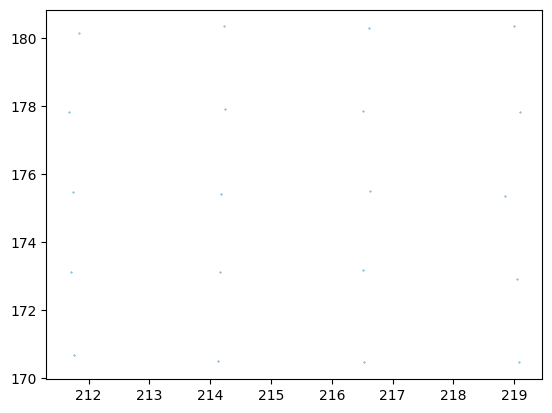

In [521]:
elreso = 5
fthin = 1
_pos1 = pos1s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]]
_pos2 = pos2s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]]
_sel = (_pos1>210)*(_pos1<220)*(_pos2>170)*(_pos2<182)
plt.scatter(_pos1[_sel],
            _pos2[_sel],s=0.1)

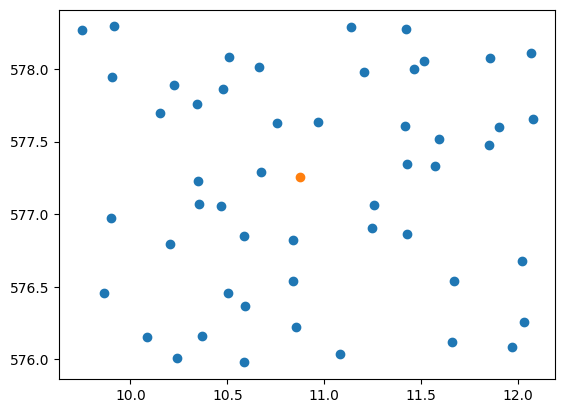

[3070801 2789842 2131514  940794  246016   61504   15376    3844] 51 29865133


In [522]:
elreso = 1
elreso2 = 5
pix_target = 1230

_lower = ngalshifts_2d[elreso*8+elreso2-1]
tmpsel = np.argwhere(pixmatcher[_lower:_lower+ngals[elreso]] == pix_target).flatten()
plt.scatter(pos1s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][tmpsel],
            pos2s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][tmpsel])
plt.scatter(pos1s[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][pix_target],
            pos2s[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][pix_target])
plt.show()
print(ngals,len(tmpsel),_lower)

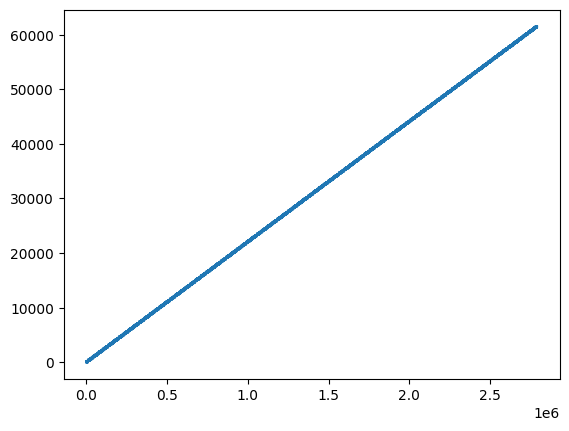

In [518]:
plt.plot(pixmatcher[_lower:_lower+ngals[elreso]])

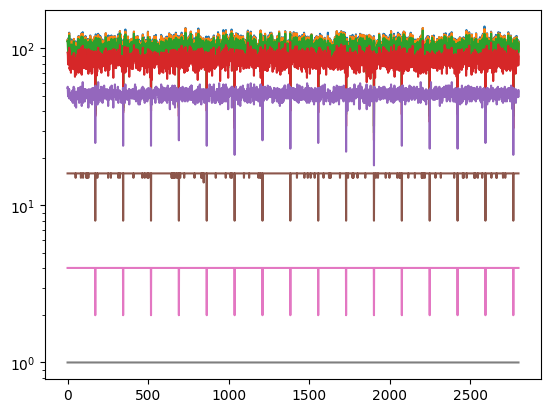

In [156]:
for i in range(8):
    plt.semilogy(pixs_galind_bounds[i][1:2801]-pixs_galind_bounds[i][:2800])

In [157]:
slicsfullreso.pix2_d,slicsfullreso.pix1_d,dpixs[-1],slicsfullreso.pix2_start+3*slicsfullreso.pix2_d,slicsfullreso.pix1_start+3*slicsfullreso.pix1_d

(3.47906416073933,
 3.479064160739329,
 3.4790643561923837,
 4.802867883846318e-05,
 9.751321837114801e-06)

In [158]:
resos2

array([0.        , 0.05436038, 0.10872076, 0.21744151, 0.43488302,
       0.86976604, 1.73953208, 3.47906416])

In [164]:
len(pixs_galind_bounds[1])

3032554

In [160]:
nresos = len(dpixs)+1
for elreso in range(nresos):
    print(ngals, len(pos1s[elreso]))
for elreso in range(nresos-1):
    for elreso2 in range(elreso,nresos-1):
        print(len(pixmatcher[elreso][elreso2-elreso]), np.max(pixmatcher[elreso][elreso2-elreso]))
       

[3070801, 3032553, 2921094, 2526571, 1524168, 475355, 119025, 29929] 3070801
[3070801, 3032553, 2921094, 2526571, 1524168, 475355, 119025, 29929] 3032553
[3070801, 3032553, 2921094, 2526571, 1524168, 475355, 119025, 29929] 2921094
[3070801, 3032553, 2921094, 2526571, 1524168, 475355, 119025, 29929] 2526571
[3070801, 3032553, 2921094, 2526571, 1524168, 475355, 119025, 29929] 1524168
[3070801, 3032553, 2921094, 2526571, 1524168, 475355, 119025, 29929] 475355
[3070801, 3032553, 2921094, 2526571, 1524168, 475355, 119025, 29929] 119025
[3070801, 3032553, 2921094, 2526571, 1524168, 475355, 119025, 29929] 29929
3070801 3032552
3070801 2921093
3070801 2526570
3070801 1524167
3070801 475354
3070801 119024
3070801 29928
3032553 2921093
3032553 2526570
3032553 1524167
3032553 475354
3032553 119024
3032553 29928
2921094 2526570
2921094 1524167
2921094 475354
2921094 119024
2921094 29928
2526571 1524167
2526571 475354
2526571 119024
2526571 29928
1524168 475354
1524168 119024
1524168 29928
475355 1

In [87]:
thisreso = 1
print(dpixs1_true[thisreso-1],dpixs2_true[thisreso-1] )
print(pos1s[thisreso][:10])
print(pos2s[thisreso][:10])

NameError: name 'dpixs1_true' is not defined

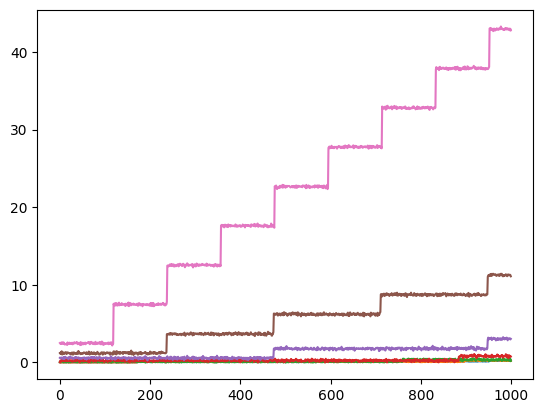

In [52]:
for i in range(1,8):
    plt.plot(pos1s[i][:1000])

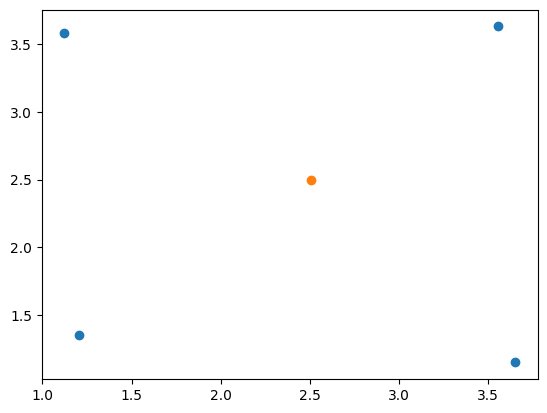

In [116]:
elreso = 6
elreso2 = 7
pix_target = 0
tmpsel = np.argwhere(pixmatcher[elreso][elreso2-elreso-1] == pix_target).flatten()
plt.scatter(pos1s[elreso][tmpsel],pos2s[elreso][tmpsel])
plt.scatter(pos1s[elreso2][pix_target],pos2s[elreso2][pix_target])
plt.show()

In [49]:
slicsfullreso.pix1_d,slicsfullreso.pix2_d

(13.628396047709527, 13.628397682162385)

In [50]:
dpixs1_true

array([ 0.21294369,  0.42588738,  0.85177475,  1.70354951,  3.40709901,
        6.81419802, 13.62839605])

In [51]:
dpixs2_true

array([ 0.21294371,  0.42588743,  0.85177486,  1.70354971,  3.40709942,
        6.81419884, 13.62839768])

In [52]:
pixmatcher

[[array([ 643210, 1696714, 2072500, ...,  225994,   24624, 1016954],
        dtype=int32),
  array([ 394391, 1042567, 1272438, ...,  138109,   14392,  624245],
        dtype=int32),
  array([125003, 330841, 404406, ...,  44112,   5020, 198381], dtype=int32),
  array([ 31431,  83206, 101775, ...,  11279,   1541,  49901], dtype=int32),
  array([ 8012, 21067, 25780, ...,  2856,   449, 12679], dtype=int32),
  array([2072, 5344, 6557, ...,  725,  137, 3262], dtype=int32),
  array([ 552, 1396, 1694, ...,  186,   69,  838], dtype=int32)],
 [array([      0,       1,       2, ..., 1563010, 1563011, 1563014],
        dtype=int32),
  array([     0,      1,      2, ..., 496544, 496544, 496546], dtype=int32),
  array([     0,      0,      1, ..., 125145, 125145, 125146], dtype=int32),
  array([    0,     0,     0, ..., 31668, 31668, 31669], dtype=int32),
  array([   0,    0,    0, ..., 8095, 8095, 8095], dtype=int32),
  array([   0,    0,    0, ..., 2111, 2111, 2111], dtype=int32)],
 [array([     0

In [53]:
thisreso = 3
print(dpixs[thisreso],dpixs1_true[thisreso],dpixs2_true[thisreso] )
print(pos1s[thisreso][:10])
print(pos2s[thisreso][:10])
print(ipix_1, ipix_2)

1.6962510983991113 1.703549505963691 1.7035497102702981
[0.0481219  0.02905559 0.10968628 0.08307612 0.05735857 0.04366506
 0.07130905 0.06595105 0.1084255  0.01290282]
[ 0.57042199  1.6831096   2.2222421   5.3906589   6.51438697  8.06451367
  8.9948559   9.7718124  12.570312   14.421894  ]
[ 2  2  2 ... 47 47 47] [ 3  3  4 ... 45 46 46]


In [56]:
slicsfullreso.pix1_n

50

In [69]:
slicsfullreso.pix2_d/resos2[5]

4.0

In [71]:
thisn2

50

In [14]:
(np.arange(23).astype(np.int32)).dtype

dtype('int32')

In [165]:
pos1s

[array([151.62956  , 399.98856  , 488.29962  , ...,  53.293072 ,
          5.6541085, 239.81259  ]),
 array([4.8121903e-02, 2.9055590e-02, 3.0522421e-02, ..., 5.9999152e+02,
        5.9999054e+02, 5.9999103e+02]),
 array([4.8121903e-02, 2.9055590e-02, 8.3076119e-02, ..., 5.9999054e+02,
        5.9999103e+02, 5.9992987e+02]),
 array([4.8121903e-02, 1.5555276e-01, 8.2262090e-02, ..., 5.9999054e+02,
        5.9999103e+02, 5.9992987e+02]),
 array([4.81219030e-02, 2.67778433e-01, 8.22620900e-02, ...,
        5.99709900e+02, 5.99838985e+02, 5.99783330e+02]),
 array([5.67591898e-01, 3.67401521e-01, 5.95274864e-01, ...,
        5.99620240e+02, 5.99472744e+02, 5.99620922e+02]),
 array([  0.90355987,   0.88504256,   0.96316298, ..., 599.18328   ,
        599.29961   , 599.27360696]),
 array([  1.81072333,   1.80294849,   1.72090595, ..., 599.24008845,
        599.22722689, 599.27360696])]

In [252]:
len(np.hstack(pixmatcher).squeeze())

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 7 and the array at index 1 has size 6

In [218]:
#pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals
allfields[0]

[array([ 2.3887389e-06,  9.0160602e-06,  2.9321502e-05, ...,
        -1.8608868e-02,  5.1830737e-03,  5.4329624e-03]),
 array([ 1.7337958e-06,  1.3832255e-05, -6.0476112e-05, ...,
        -8.6770132e-03, -2.9979378e-02,  2.7184695e-02])]

In [190]:
np.sqrt(253472/8)

178.0

In [206]:
resos1

array([0.        , 0.05436038, 0.10872076, 0.21744151, 0.43488302,
       0.86976604, 1.73953208, 3.47906416])

In [208]:
slicsfullreso.pix2_n

178

In [221]:
type(allfields[0][0])

numpy.ndarray

In [223]:
isinstance(allfields[0], list)
isinstance(allfields[0][0], np.ndarray)

True

In [267]:
print(len(pixmatcher))
for p in pixmatcher:
    print(len(p), len(p[0]), np.max(p))

7
7 3070801 3032552
6 3032553 2921093
5 2921094 2526570
4 2526571 1524167
3 1524168 475354
2 475355 119024
1 119025 29928


In [294]:
_tmpshift = 0
ngalshifts_2d = -1*np.ones((len(pixmatcher),len(pixmatcher)+1), dtype=np.int32)
for elreso in range(nresos-1):
    ngalshifts_2d[elreso][elreso] = _tmpshift
    for elreso2 in range(elreso+1,nresos):
        _tmpshift += ngals[elreso]
        ngalshifts_2d[elreso][elreso2] = _tmpshift
ngalshifts_2d

array([[       0,  3070801,  6141602,  9212403, 12283204, 15354005,
        18424806, 21495607],
       [      -1, 21495607, 24528160, 27560713, 30593266, 33625819,
        36658372, 39690925],
       [      -1,       -1, 39690925, 42612019, 45533113, 48454207,
        51375301, 54296395],
       [      -1,       -1,       -1, 54296395, 56822966, 59349537,
        61876108, 64402679],
       [      -1,       -1,       -1,       -1, 64402679, 65926847,
        67451015, 68975183],
       [      -1,       -1,       -1,       -1,       -1, 68975183,
        69450538, 69925893],
       [      -1,       -1,       -1,       -1,       -1,       -1,
        69925893, 70044918]], dtype=int32)

In [273]:
ngals

[3070801, 3032553, 2921094, 2526571, 1524168, 475355, 119025, 29929]

In [277]:
len(pixmatcher)

7

In [285]:
7*ngals[0]+6*ngals[1]+5*ngals[2]+4*ngals[3]+3*ngals[4]+2*ngals[5]+ngals[6]

70044918

In [286]:
resoshift2d[-1][-1]

70044918

In [ ]:
1

In [26]:
rmin = 0.5
rmax = 200.
nbinsr = 40
redges = np.geomspace(rmin,rmax,nbinsr+1)
dr = np.log(rmax/rmin)/nbinsr
target_edges = [0.5, 5., 10., 20., 40., 80.,200.]
tmpr = rmin
tmpreso = 0
resoideges_base = [0]*len(target_edges)
resoideges_better = [0]*len(target_edges)
for elr in range(len(redges)-1):
    tmpr = rmin*np.e**((elr+1)*dr)
    if (tmpr > target_edges[tmpreso+1]):
        #print(elr, tmpr, target_edges[tmpreso+1])
        #print(tmpr-target_edges[tmpreso+1], target_edges[tmpreso+1] - (tmpr/np.e**dr))
        resoideges_base[tmpreso+1] = elr
        resoideges_better[tmpreso+1] = elr + int((tmpr-target_edges[tmpreso+1])<(target_edges[tmpreso+1] - (tmpr/np.e**dr)))
        tmpreso += 1
print(resoideges_base)
print(resoideges_better)
print(redges[resoideges_base]) 
print(redges[resoideges_better]) 

[0, 15, 20, 24, 29, 33, 0]
[0, 15, 20, 25, 29, 34, 0]
[ 0.5         4.72870805 10.         18.20564203 38.50024543 70.09216864
  0.5       ]
[ 0.5         4.72870805 10.         21.14742527 38.50024543 81.41810631
  0.5       ]
